In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v003.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [ ]:
%autoreload
bioqic = mre_pinn.data.BIOQICFEMBox('../data/BIOQIC/downloads')
bioqic.download()
bioqic.load_mat()
bioqic.preprocess()
dataset = bioqic.to_dataset()
dataset.save_xarrays('../data/BIOQIC/fem_box')

In [3]:
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', 60)
example.metadata

Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc


size  spacing  origin  limit  center  extent
variable dimension                                              
wave     x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre      x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre_mask x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01

In [4]:
example.describe()

dtype    count                     mean          std  \
variable component                                                              
wave     y          complex128  80000.0  -0.00000100-0.00001000j     0.000724   
         x          complex128  80000.0   0.00022200-0.00020700j     0.000742   
         z          complex128  80000.0   0.00092400+0.00005900j     0.012493   
mre      scalar     complex128  80000.0  3382.375000+376.991118j  1590.727619   
mre_mask scalar          int64  80000.0   1.07650000+0.00000000j     0.362143   

                                        min                      25%  \
variable component                                                     
wave     y          -0.00198900-0.00084800j  -0.00031600+0.00029700j   
         x          -0.00271700+0.00009800j  -0.00007000-0.00019200j   
         z          -0.02294100-0.00252200j  -0.00443200-0.00007700j   
mre      scalar     3000.000000+376.991118j  3000.000000+376.991118j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                        50%                      75%  \
variable component                                                     
wave     y           0.00002900+0.00024900j   0.00031500+0.00007300j   
         x           0.00017900+0.00008700j   0.00053800-0.00078400j   
         z           0.00069400+0.00010000j   0.00689700-0.01260300j   
mre      scalar     3000.000000+376.991118j  3000.000000+376.991118j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                         max  
variable component                            
wave     y          0.001772000+0.000765000j  
         x          0.002784000-0.001559000j  
         z          0.022754000+0.005157000j  
mre      scalar     10000.000000+376.991118j  
mre_mask scalar     5.000000000+0.000000000j

<IPython.core.display.Javascript object>


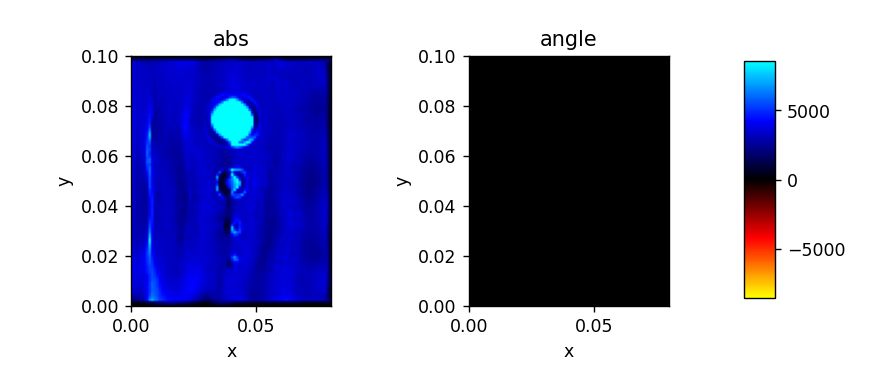

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [7]:
%autoreload
example.eval_baseline(frequency=example.wave.frequency.item(), polar=True)
example.view('base', ax_height=2, ax_width=2, col='part', polar=True)

In [8]:
pde = mre_pinn.pde.WaveEquation.from_name('hetero', omega=example.wave.frequency.item(), detach=True)

In [9]:
%autoreload
pinn = mre_pinn.model.MREPINN(
    example,
    omega=30,
    n_layers=5,
    n_hidden=128,
    polar_input=False,
    conditional=False
)
pinn

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (hidden3): Linear(in_features=387, out_features=128, bias=True)
    (output): Linear(in_features=515, out_features=6, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (hidden3): Linear(in_features=387, out_features=128, bias=True)
    (output): Linear(in_features=515, out_features=2, bias=True)
  )
)

In [10]:
%autoreload
model = mre_pinn.training.MREPINNModel(
    example, pinn, pde,
    loss_weights=[1, 0, 1e-8],
    pde_warmup_iters=5000,
    pde_step_iters=5000,
    pde_init_weight=1e-10,
    n_points=1024
)
model.compile(optimizer='adam', lr=1e-4, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000258 s



In [11]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(100)

# iterations: 100
Data time/iter:  0.0032s (2.74%)
Model time/iter: 0.0547s (47.48%)
Loss time/iter:  0.0574s (49.78%)
Total time/iter: 0.1153s
Total time: 11.5276s
1k iters time: 1.92m
10k iters time: 19.21m
100k iters time: 3.20h


<IPython.core.display.Javascript object>


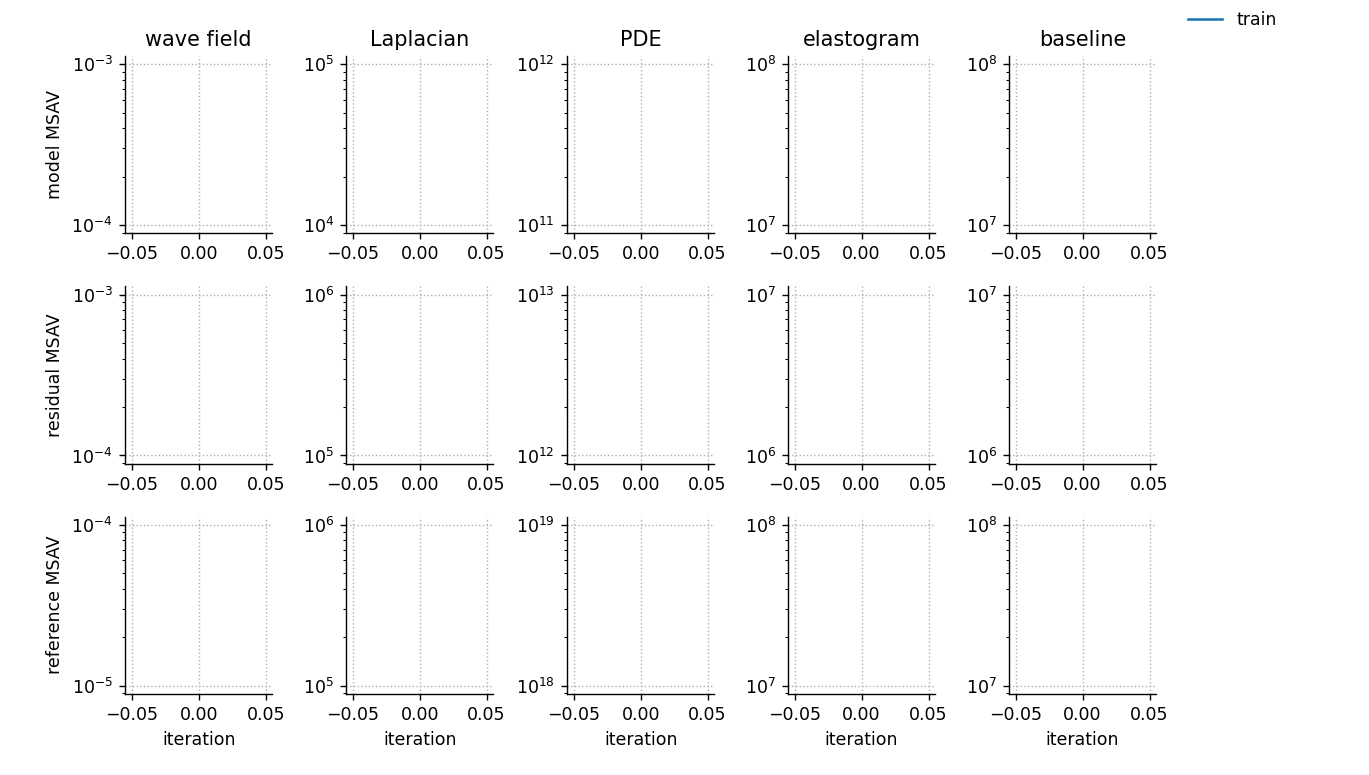

<IPython.core.display.Javascript object>


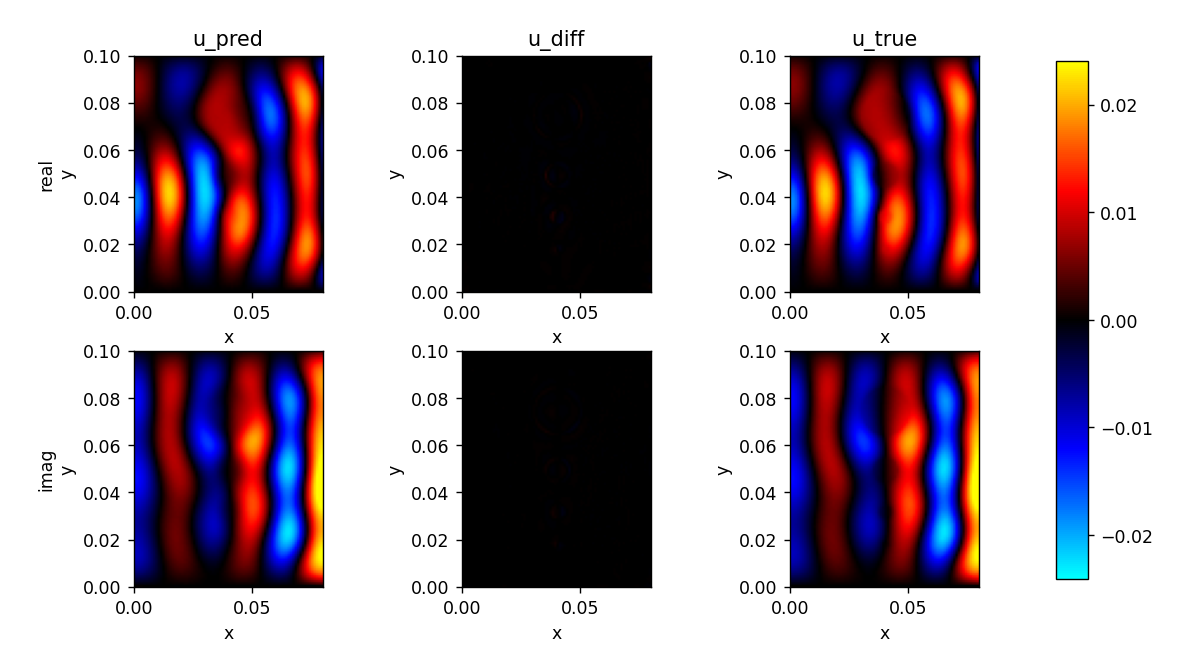

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


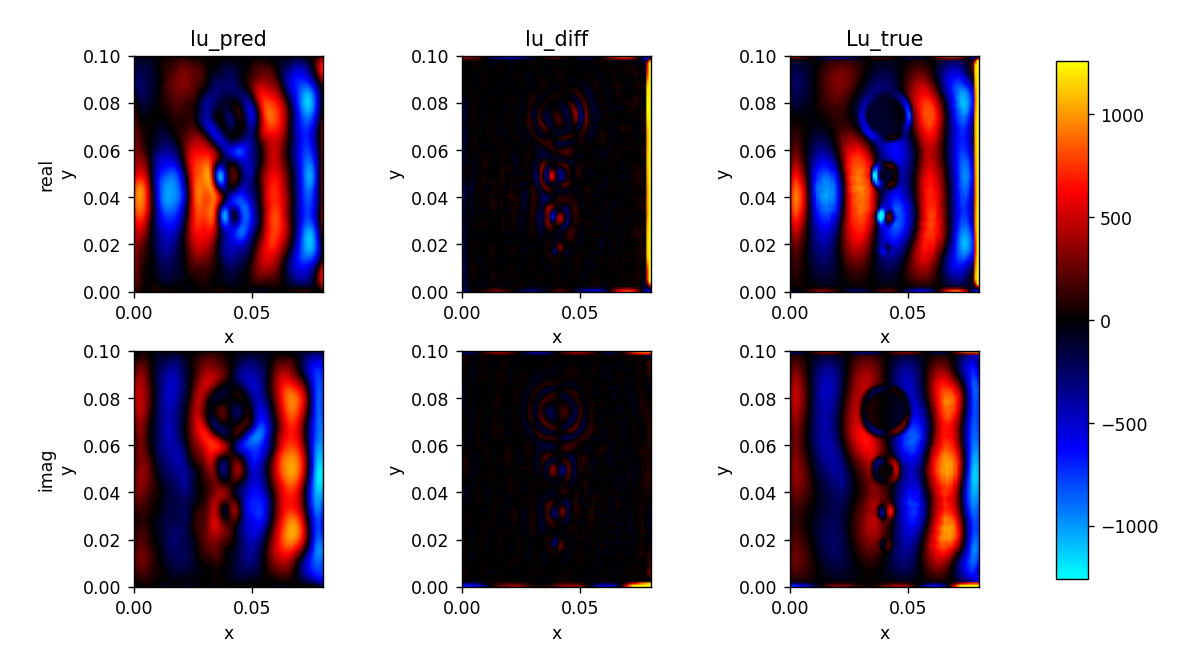

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


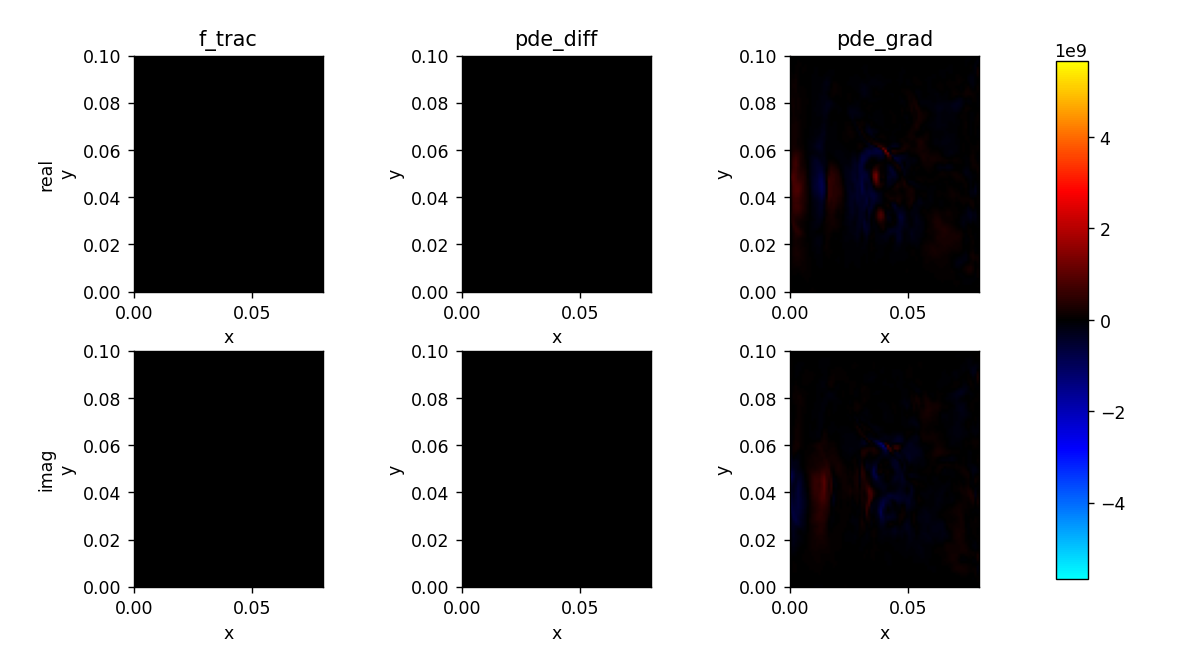

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


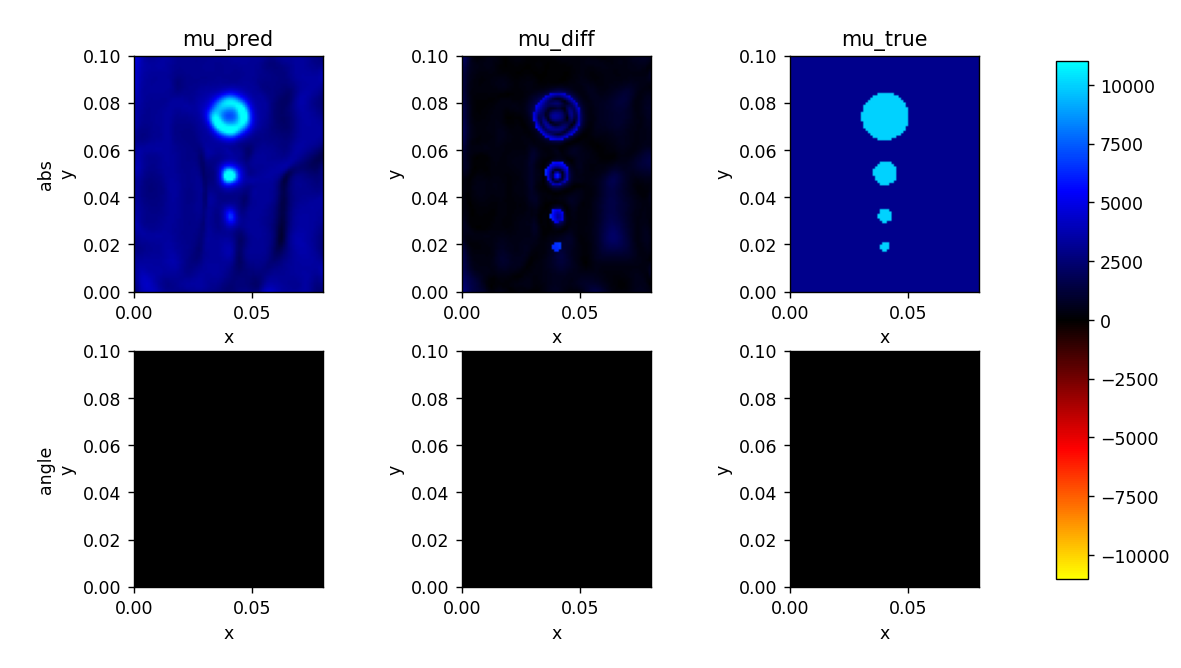

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


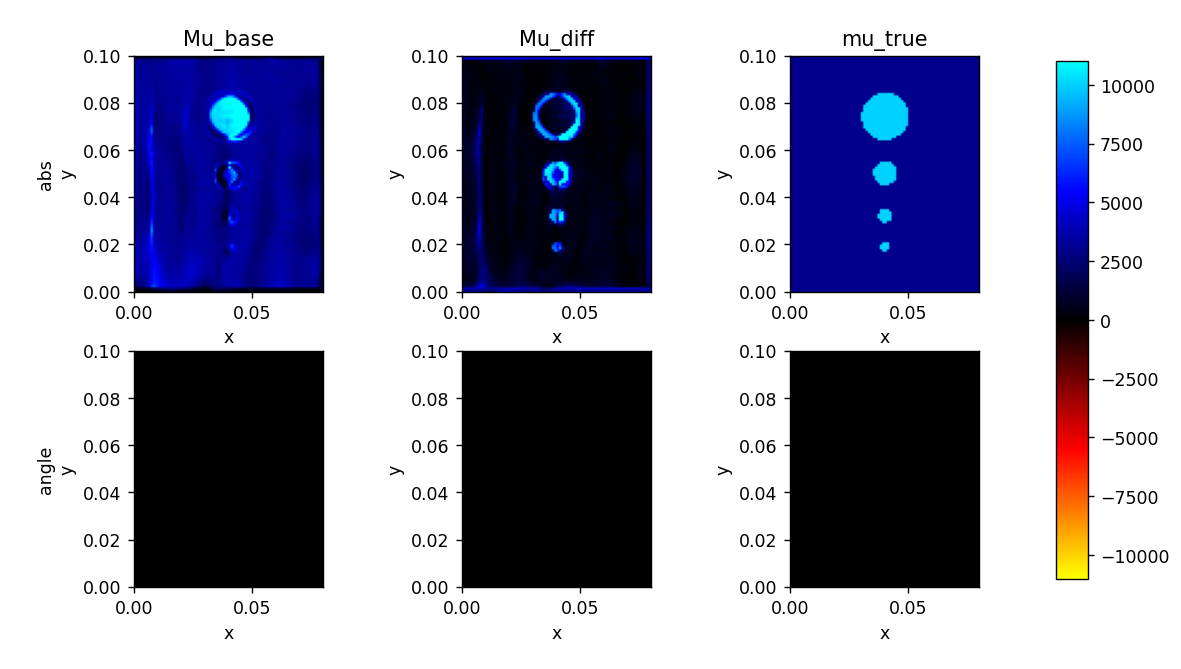

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [12]:
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)
test_eval.model = model
test_eval.test()

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.48e-04, 0.00e+00, 0.00e+00]    [2.35e-04, 0.00e+00, 0.00e+00]    []  


<IPython.core.display.Javascript object>


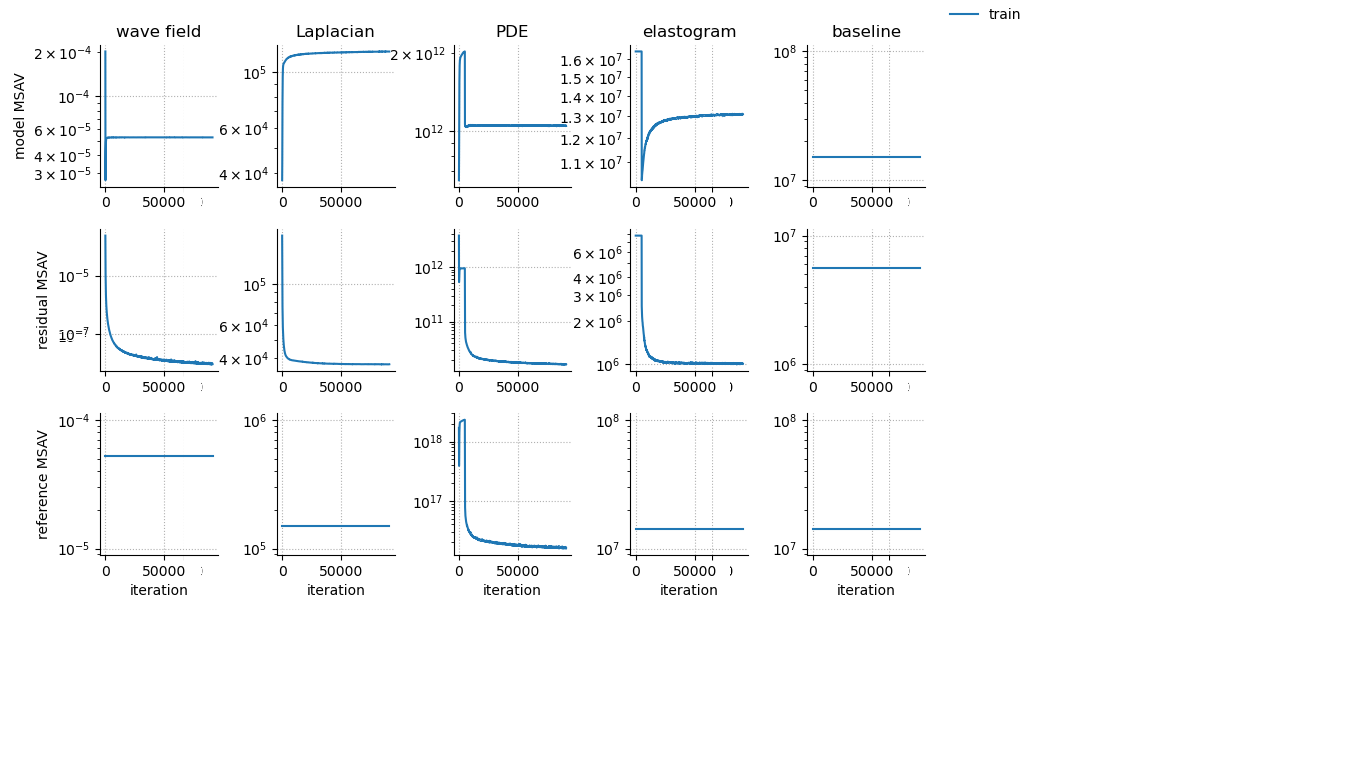

Time spent testing: 14.9642 (26.11%)
10        [1.38e-04, 0.00e+00, 0.00e+00]    [1.37e-04, 0.00e+00, 0.00e+00]    []  
20        [8.64e-05, 0.00e+00, 0.00e+00]    [8.54e-05, 0.00e+00, 0.00e+00]    []  
30        [6.56e-05, 0.00e+00, 0.00e+00]    [6.33e-05, 0.00e+00, 0.00e+00]    []  
40        [5.25e-05, 0.00e+00, 0.00e+00]    [5.24e-05, 0.00e+00, 0.00e+00]    []  
50        [4.27e-05, 0.00e+00, 0.00e+00]    [4.46e-05, 0.00e+00, 0.00e+00]    []  
60        [3.77e-05, 0.00e+00, 0.00e+00]    [3.86e-05, 0.00e+00, 0.00e+00]    []  
70        [3.30e-05, 0.00e+00, 0.00e+00]    [3.38e-05, 0.00e+00, 0.00e+00]    []  
80        [2.93e-05, 0.00e+00, 0.00e+00]    [3.00e-05, 0.00e+00, 0.00e+00]    []  
90        [2.78e-05, 0.00e+00, 0.00e+00]    [2.69e-05, 0.00e+00, 0.00e+00]    []  
100       [2.34e-05, 0.00e+00, 0.00e+00]    [2.42e-05, 0.00e+00, 0.00e+00]    []  
Time spent testing: 14.0757 (36.97%)
110       [2.05e-05, 0.00e+00, 0.00e+00]    [2.20e-05, 0.00e+00, 0.00e+00]    []  
120       [2.

960       [7.51e-07, 0.00e+00, 0.00e+00]    [7.57e-07, 0.00e+00, 0.00e+00]    []  
970       [7.43e-07, 0.00e+00, 0.00e+00]    [7.40e-07, 0.00e+00, 0.00e+00]    []  
980       [6.64e-07, 0.00e+00, 0.00e+00]    [7.30e-07, 0.00e+00, 0.00e+00]    []  
990       [7.16e-07, 0.00e+00, 0.00e+00]    [7.27e-07, 0.00e+00, 0.00e+00]    []  
1000      [6.78e-07, 0.00e+00, 0.00e+00]    [7.11e-07, 0.00e+00, 0.00e+00]    []  
Time spent testing: 14.5379 (57.76%)
1010      [6.95e-07, 0.00e+00, 0.00e+00]    [7.01e-07, 0.00e+00, 0.00e+00]    []  
1020      [6.46e-07, 0.00e+00, 0.00e+00]    [6.91e-07, 0.00e+00, 0.00e+00]    []  
1030      [6.65e-07, 0.00e+00, 0.00e+00]    [6.81e-07, 0.00e+00, 0.00e+00]    []  
1040      [6.15e-07, 0.00e+00, 0.00e+00]    [6.75e-07, 0.00e+00, 0.00e+00]    []  
1050      [6.51e-07, 0.00e+00, 0.00e+00]    [6.65e-07, 0.00e+00, 0.00e+00]    []  
1060      [6.17e-07, 0.00e+00, 0.00e+00]    [6.54e-07, 0.00e+00, 0.00e+00]    []  
1070      [6.11e-07, 0.00e+00, 0.00e+00]    [6.45e

Time spent testing: 14.4958 (61.08%)
1910      [2.84e-07, 0.00e+00, 0.00e+00]    [2.81e-07, 0.00e+00, 0.00e+00]    []  
1920      [2.53e-07, 0.00e+00, 0.00e+00]    [2.80e-07, 0.00e+00, 0.00e+00]    []  
1930      [2.64e-07, 0.00e+00, 0.00e+00]    [2.77e-07, 0.00e+00, 0.00e+00]    []  
1940      [2.53e-07, 0.00e+00, 0.00e+00]    [2.76e-07, 0.00e+00, 0.00e+00]    []  
1950      [2.71e-07, 0.00e+00, 0.00e+00]    [2.74e-07, 0.00e+00, 0.00e+00]    []  
1960      [2.78e-07, 0.00e+00, 0.00e+00]    [2.72e-07, 0.00e+00, 0.00e+00]    []  
1970      [2.68e-07, 0.00e+00, 0.00e+00]    [2.68e-07, 0.00e+00, 0.00e+00]    []  
1980      [2.48e-07, 0.00e+00, 0.00e+00]    [2.66e-07, 0.00e+00, 0.00e+00]    []  
1990      [2.48e-07, 0.00e+00, 0.00e+00]    [2.66e-07, 0.00e+00, 0.00e+00]    []  
2000      [2.65e-07, 0.00e+00, 0.00e+00]    [2.63e-07, 0.00e+00, 0.00e+00]    []  
Time spent testing: 14.5916 (61.31%)
2010      [2.28e-07, 0.00e+00, 0.00e+00]    [2.61e-07, 0.00e+00, 0.00e+00]    []  
2020      [2.

2860      [1.52e-07, 0.00e+00, 0.00e+00]    [1.60e-07, 0.00e+00, 0.00e+00]    []  
2870      [1.57e-07, 0.00e+00, 0.00e+00]    [1.59e-07, 0.00e+00, 0.00e+00]    []  
2880      [1.59e-07, 0.00e+00, 0.00e+00]    [1.59e-07, 0.00e+00, 0.00e+00]    []  
2890      [1.44e-07, 0.00e+00, 0.00e+00]    [1.58e-07, 0.00e+00, 0.00e+00]    []  
2900      [1.60e-07, 0.00e+00, 0.00e+00]    [1.56e-07, 0.00e+00, 0.00e+00]    []  
Time spent testing: 14.7862 (62.45%)
2910      [1.60e-07, 0.00e+00, 0.00e+00]    [1.55e-07, 0.00e+00, 0.00e+00]    []  
2920      [1.41e-07, 0.00e+00, 0.00e+00]    [1.55e-07, 0.00e+00, 0.00e+00]    []  
2930      [1.42e-07, 0.00e+00, 0.00e+00]    [1.54e-07, 0.00e+00, 0.00e+00]    []  
2940      [1.46e-07, 0.00e+00, 0.00e+00]    [1.54e-07, 0.00e+00, 0.00e+00]    []  
2950      [1.45e-07, 0.00e+00, 0.00e+00]    [1.52e-07, 0.00e+00, 0.00e+00]    []  
2960      [1.58e-07, 0.00e+00, 0.00e+00]    [1.52e-07, 0.00e+00, 0.00e+00]    []  
2970      [1.54e-07, 0.00e+00, 0.00e+00]    [1.54e

Time spent testing: 15.0000 (63.08%)
3810      [1.04e-07, 0.00e+00, 0.00e+00]    [1.07e-07, 0.00e+00, 0.00e+00]    []  
3820      [1.03e-07, 0.00e+00, 0.00e+00]    [1.06e-07, 0.00e+00, 0.00e+00]    []  
3830      [1.06e-07, 0.00e+00, 0.00e+00]    [1.06e-07, 0.00e+00, 0.00e+00]    []  
3840      [1.05e-07, 0.00e+00, 0.00e+00]    [1.06e-07, 0.00e+00, 0.00e+00]    []  
3850      [1.02e-07, 0.00e+00, 0.00e+00]    [1.06e-07, 0.00e+00, 0.00e+00]    []  
3860      [1.04e-07, 0.00e+00, 0.00e+00]    [1.06e-07, 0.00e+00, 0.00e+00]    []  
3870      [1.11e-07, 0.00e+00, 0.00e+00]    [1.04e-07, 0.00e+00, 0.00e+00]    []  
3880      [9.61e-08, 0.00e+00, 0.00e+00]    [1.05e-07, 0.00e+00, 0.00e+00]    []  
3890      [9.61e-08, 0.00e+00, 0.00e+00]    [1.04e-07, 0.00e+00, 0.00e+00]    []  
3900      [1.05e-07, 0.00e+00, 0.00e+00]    [1.05e-07, 0.00e+00, 0.00e+00]    []  
Time spent testing: 14.3173 (63.11%)
3910      [9.75e-08, 0.00e+00, 0.00e+00]    [1.03e-07, 0.00e+00, 0.00e+00]    []  
3920      [1.

4760      [7.20e-08, 0.00e+00, 0.00e+00]    [7.85e-08, 0.00e+00, 0.00e+00]    []  
4770      [1.39e-07, 0.00e+00, 0.00e+00]    [8.03e-08, 0.00e+00, 0.00e+00]    []  
4780      [7.59e-08, 0.00e+00, 0.00e+00]    [7.94e-08, 0.00e+00, 0.00e+00]    []  
4790      [6.54e-08, 0.00e+00, 0.00e+00]    [7.91e-08, 0.00e+00, 0.00e+00]    []  
4800      [7.66e-08, 0.00e+00, 0.00e+00]    [7.83e-08, 0.00e+00, 0.00e+00]    []  
Time spent testing: 14.8848 (63.42%)
4810      [7.12e-08, 0.00e+00, 0.00e+00]    [7.73e-08, 0.00e+00, 0.00e+00]    []  
4820      [7.21e-08, 0.00e+00, 0.00e+00]    [7.73e-08, 0.00e+00, 0.00e+00]    []  
4830      [7.38e-08, 0.00e+00, 0.00e+00]    [7.84e-08, 0.00e+00, 0.00e+00]    []  
4840      [7.28e-08, 0.00e+00, 0.00e+00]    [7.86e-08, 0.00e+00, 0.00e+00]    []  
4850      [7.91e-08, 0.00e+00, 0.00e+00]    [7.88e-08, 0.00e+00, 0.00e+00]    []  
4860      [6.96e-08, 0.00e+00, 0.00e+00]    [7.79e-08, 0.00e+00, 0.00e+00]    []  
4870      [7.42e-08, 0.00e+00, 0.00e+00]    [7.84e

Time spent testing: 13.9439 (63.72%)
5710      [5.76e-08, 0.00e+00, 4.21e+00]    [6.33e-08, 0.00e+00, 4.72e+00]    []  
5720      [5.67e-08, 0.00e+00, 4.49e+00]    [6.24e-08, 0.00e+00, 4.64e+00]    []  
5730      [6.26e-08, 0.00e+00, 4.62e+00]    [6.22e-08, 0.00e+00, 4.63e+00]    []  
5740      [6.01e-08, 0.00e+00, 4.47e+00]    [6.26e-08, 0.00e+00, 4.65e+00]    []  
5750      [6.26e-08, 0.00e+00, 4.64e+00]    [6.17e-08, 0.00e+00, 4.63e+00]    []  
5760      [5.62e-08, 0.00e+00, 4.96e+00]    [6.16e-08, 0.00e+00, 4.64e+00]    []  
5770      [5.91e-08, 0.00e+00, 4.22e+00]    [6.22e-08, 0.00e+00, 4.55e+00]    []  
5780      [5.58e-08, 0.00e+00, 4.26e+00]    [6.16e-08, 0.00e+00, 4.56e+00]    []  
5790      [6.23e-08, 0.00e+00, 4.48e+00]    [6.22e-08, 0.00e+00, 4.54e+00]    []  
5800      [5.50e-08, 0.00e+00, 4.24e+00]    [6.17e-08, 0.00e+00, 4.54e+00]    []  
Time spent testing: 14.2400 (63.74%)
5810      [6.34e-08, 0.00e+00, 4.34e+00]    [6.17e-08, 0.00e+00, 4.55e+00]    []  
5820      [5.

6660      [4.83e-08, 0.00e+00, 3.57e+00]    [5.12e-08, 0.00e+00, 3.68e+00]    []  
6670      [4.77e-08, 0.00e+00, 3.75e+00]    [5.16e-08, 0.00e+00, 3.68e+00]    []  
6680      [4.81e-08, 0.00e+00, 3.66e+00]    [5.17e-08, 0.00e+00, 3.64e+00]    []  
6690      [5.30e-08, 0.00e+00, 3.75e+00]    [5.18e-08, 0.00e+00, 3.64e+00]    []  
6700      [5.70e-08, 0.00e+00, 3.62e+00]    [5.20e-08, 0.00e+00, 3.64e+00]    []  
Time spent testing: 14.6256 (63.87%)
6710      [4.83e-08, 0.00e+00, 3.38e+00]    [5.06e-08, 0.00e+00, 3.63e+00]    []  
6720      [4.90e-08, 0.00e+00, 3.72e+00]    [5.21e-08, 0.00e+00, 3.67e+00]    []  
6730      [5.02e-08, 0.00e+00, 3.45e+00]    [5.17e-08, 0.00e+00, 3.68e+00]    []  
6740      [5.06e-08, 0.00e+00, 3.87e+00]    [5.14e-08, 0.00e+00, 3.69e+00]    []  
6750      [4.68e-08, 0.00e+00, 3.82e+00]    [5.12e-08, 0.00e+00, 3.69e+00]    []  
6760      [5.31e-08, 0.00e+00, 3.59e+00]    [5.00e-08, 0.00e+00, 3.63e+00]    []  
6770      [4.82e-08, 0.00e+00, 3.63e+00]    [5.00e

Time spent testing: 14.6864 (63.89%)
7610      [4.58e-08, 0.00e+00, 3.48e+00]    [4.46e-08, 0.00e+00, 3.28e+00]    []  
7620      [4.07e-08, 0.00e+00, 3.07e+00]    [4.36e-08, 0.00e+00, 3.24e+00]    []  
7630      [4.19e-08, 0.00e+00, 3.47e+00]    [4.37e-08, 0.00e+00, 3.32e+00]    []  
7640      [4.05e-08, 0.00e+00, 3.35e+00]    [4.49e-08, 0.00e+00, 3.29e+00]    []  
7650      [4.17e-08, 0.00e+00, 3.14e+00]    [4.40e-08, 0.00e+00, 3.28e+00]    []  
7660      [4.43e-08, 0.00e+00, 3.25e+00]    [4.32e-08, 0.00e+00, 3.27e+00]    []  
7670      [4.18e-08, 0.00e+00, 3.41e+00]    [4.33e-08, 0.00e+00, 3.27e+00]    []  
7680      [4.05e-08, 0.00e+00, 3.48e+00]    [4.36e-08, 0.00e+00, 3.23e+00]    []  
7690      [4.12e-08, 0.00e+00, 3.28e+00]    [4.39e-08, 0.00e+00, 3.23e+00]    []  
7700      [3.91e-08, 0.00e+00, 3.34e+00]    [4.41e-08, 0.00e+00, 3.26e+00]    []  
Time spent testing: 15.1983 (63.91%)
7710      [4.17e-08, 0.00e+00, 3.17e+00]    [4.30e-08, 0.00e+00, 3.23e+00]    []  
7720      [4.

8560      [3.65e-08, 0.00e+00, 2.77e+00]    [3.87e-08, 0.00e+00, 2.92e+00]    []  
8570      [4.07e-08, 0.00e+00, 2.83e+00]    [3.92e-08, 0.00e+00, 2.94e+00]    []  
8580      [3.84e-08, 0.00e+00, 3.00e+00]    [3.94e-08, 0.00e+00, 2.96e+00]    []  
8590      [3.46e-08, 0.00e+00, 2.93e+00]    [4.04e-08, 0.00e+00, 2.98e+00]    []  
8600      [4.15e-08, 0.00e+00, 2.85e+00]    [3.95e-08, 0.00e+00, 2.98e+00]    []  
Time spent testing: 14.7175 (63.96%)
8610      [3.72e-08, 0.00e+00, 2.77e+00]    [3.95e-08, 0.00e+00, 2.96e+00]    []  
8620      [3.70e-08, 0.00e+00, 2.86e+00]    [3.93e-08, 0.00e+00, 2.99e+00]    []  
8630      [3.42e-08, 0.00e+00, 2.82e+00]    [3.97e-08, 0.00e+00, 2.93e+00]    []  
8640      [3.56e-08, 0.00e+00, 3.14e+00]    [3.79e-08, 0.00e+00, 2.99e+00]    []  
8650      [3.70e-08, 0.00e+00, 2.81e+00]    [3.93e-08, 0.00e+00, 2.99e+00]    []  
8660      [3.40e-08, 0.00e+00, 3.05e+00]    [3.88e-08, 0.00e+00, 2.97e+00]    []  
8670      [4.22e-08, 0.00e+00, 3.07e+00]    [3.84e

Time spent testing: 15.1094 (64.01%)
9510      [2.87e-08, 0.00e+00, 2.54e+00]    [3.45e-08, 0.00e+00, 2.74e+00]    []  
9520      [2.97e-08, 0.00e+00, 2.52e+00]    [3.47e-08, 0.00e+00, 2.76e+00]    []  
9530      [3.15e-08, 0.00e+00, 2.78e+00]    [3.60e-08, 0.00e+00, 2.75e+00]    []  
9540      [3.34e-08, 0.00e+00, 2.76e+00]    [3.58e-08, 0.00e+00, 2.79e+00]    []  
9550      [2.98e-08, 0.00e+00, 2.65e+00]    [3.55e-08, 0.00e+00, 2.77e+00]    []  
9560      [3.32e-08, 0.00e+00, 2.73e+00]    [3.50e-08, 0.00e+00, 2.75e+00]    []  
9570      [3.47e-08, 0.00e+00, 2.74e+00]    [3.46e-08, 0.00e+00, 2.73e+00]    []  
9580      [2.98e-08, 0.00e+00, 2.70e+00]    [3.44e-08, 0.00e+00, 2.75e+00]    []  
9590      [3.22e-08, 0.00e+00, 2.89e+00]    [3.46e-08, 0.00e+00, 2.73e+00]    []  
9600      [2.96e-08, 0.00e+00, 2.63e+00]    [3.47e-08, 0.00e+00, 2.77e+00]    []  
Time spent testing: 15.1936 (64.02%)
9610      [3.24e-08, 0.00e+00, 2.61e+00]    [3.52e-08, 0.00e+00, 2.76e+00]    []  
9620      [3.

10460     [3.04e-08, 0.00e+00, 2.54e+01]    [3.28e-08, 0.00e+00, 2.61e+01]    []  
10470     [3.24e-08, 0.00e+00, 2.54e+01]    [3.23e-08, 0.00e+00, 2.56e+01]    []  
10480     [3.24e-08, 0.00e+00, 2.71e+01]    [3.19e-08, 0.00e+00, 2.54e+01]    []  
10490     [2.85e-08, 0.00e+00, 2.42e+01]    [3.23e-08, 0.00e+00, 2.47e+01]    []  
10500     [2.92e-08, 0.00e+00, 2.36e+01]    [3.16e-08, 0.00e+00, 2.52e+01]    []  
Time spent testing: 15.4064 (64.07%)
10510     [2.62e-08, 0.00e+00, 2.48e+01]    [3.26e-08, 0.00e+00, 2.50e+01]    []  
10520     [3.36e-08, 0.00e+00, 2.57e+01]    [3.21e-08, 0.00e+00, 2.51e+01]    []  
10530     [3.01e-08, 0.00e+00, 2.50e+01]    [3.26e-08, 0.00e+00, 2.47e+01]    []  
10540     [3.53e-08, 0.00e+00, 2.51e+01]    [3.19e-08, 0.00e+00, 2.51e+01]    []  
10550     [2.93e-08, 0.00e+00, 2.42e+01]    [3.12e-08, 0.00e+00, 2.52e+01]    []  
10560     [2.89e-08, 0.00e+00, 2.47e+01]    [3.15e-08, 0.00e+00, 2.47e+01]    []  
10570     [3.01e-08, 0.00e+00, 2.73e+01]    [3.16e

Time spent testing: 15.1308 (64.09%)
11410     [3.27e-08, 0.00e+00, 2.36e+01]    [2.99e-08, 0.00e+00, 2.43e+01]    []  
11420     [2.71e-08, 0.00e+00, 2.26e+01]    [2.99e-08, 0.00e+00, 2.40e+01]    []  
11430     [3.09e-08, 0.00e+00, 2.38e+01]    [2.98e-08, 0.00e+00, 2.38e+01]    []  
11440     [2.77e-08, 0.00e+00, 2.31e+01]    [3.01e-08, 0.00e+00, 2.35e+01]    []  
11450     [2.66e-08, 0.00e+00, 2.38e+01]    [2.97e-08, 0.00e+00, 2.38e+01]    []  
11460     [2.92e-08, 0.00e+00, 2.25e+01]    [2.96e-08, 0.00e+00, 2.35e+01]    []  
11470     [2.87e-08, 0.00e+00, 2.59e+01]    [3.09e-08, 0.00e+00, 2.37e+01]    []  
11480     [2.89e-08, 0.00e+00, 2.36e+01]    [2.97e-08, 0.00e+00, 2.32e+01]    []  
11490     [2.57e-08, 0.00e+00, 2.29e+01]    [2.95e-08, 0.00e+00, 2.37e+01]    []  
11500     [2.96e-08, 0.00e+00, 2.63e+01]    [2.94e-08, 0.00e+00, 2.35e+01]    []  
Time spent testing: 15.8302 (64.11%)
11510     [2.83e-08, 0.00e+00, 2.46e+01]    [2.93e-08, 0.00e+00, 2.39e+01]    []  
11520     [2.

12360     [2.92e-08, 0.00e+00, 2.35e+01]    [2.87e-08, 0.00e+00, 2.32e+01]    []  
12370     [2.91e-08, 0.00e+00, 2.24e+01]    [2.81e-08, 0.00e+00, 2.35e+01]    []  
12380     [2.74e-08, 0.00e+00, 2.20e+01]    [2.78e-08, 0.00e+00, 2.31e+01]    []  
12390     [2.58e-08, 0.00e+00, 2.25e+01]    [2.73e-08, 0.00e+00, 2.32e+01]    []  
12400     [2.38e-08, 0.00e+00, 2.21e+01]    [2.78e-08, 0.00e+00, 2.27e+01]    []  
Time spent testing: 15.1955 (64.11%)
12410     [2.27e-08, 0.00e+00, 2.18e+01]    [2.80e-08, 0.00e+00, 2.27e+01]    []  
12420     [2.45e-08, 0.00e+00, 2.44e+01]    [2.83e-08, 0.00e+00, 2.33e+01]    []  
12430     [2.41e-08, 0.00e+00, 2.16e+01]    [2.73e-08, 0.00e+00, 2.31e+01]    []  
12440     [2.98e-08, 0.00e+00, 2.37e+01]    [2.79e-08, 0.00e+00, 2.31e+01]    []  
12450     [2.28e-08, 0.00e+00, 2.15e+01]    [2.82e-08, 0.00e+00, 2.35e+01]    []  
12460     [2.93e-08, 0.00e+00, 2.42e+01]    [2.89e-08, 0.00e+00, 2.30e+01]    []  
12470     [2.74e-08, 0.00e+00, 2.32e+01]    [2.83e

Time spent testing: 16.1878 (64.14%)
13310     [2.24e-08, 0.00e+00, 2.11e+01]    [2.62e-08, 0.00e+00, 2.32e+01]    []  
13320     [2.25e-08, 0.00e+00, 2.25e+01]    [2.66e-08, 0.00e+00, 2.31e+01]    []  
13330     [2.20e-08, 0.00e+00, 2.28e+01]    [2.68e-08, 0.00e+00, 2.27e+01]    []  
13340     [2.23e-08, 0.00e+00, 2.19e+01]    [2.59e-08, 0.00e+00, 2.27e+01]    []  
13350     [2.36e-08, 0.00e+00, 2.11e+01]    [2.58e-08, 0.00e+00, 2.30e+01]    []  
13360     [2.10e-08, 0.00e+00, 2.20e+01]    [2.57e-08, 0.00e+00, 2.24e+01]    []  
13370     [2.05e-08, 0.00e+00, 2.06e+01]    [2.61e-08, 0.00e+00, 2.25e+01]    []  
13380     [2.42e-08, 0.00e+00, 2.33e+01]    [2.65e-08, 0.00e+00, 2.26e+01]    []  
13390     [2.43e-08, 0.00e+00, 2.42e+01]    [2.60e-08, 0.00e+00, 2.24e+01]    []  
13400     [2.86e-08, 0.00e+00, 2.32e+01]    [2.58e-08, 0.00e+00, 2.25e+01]    []  
Time spent testing: 16.2898 (64.15%)
13410     [2.85e-08, 0.00e+00, 2.31e+01]    [2.63e-08, 0.00e+00, 2.22e+01]    []  
13420     [2.

14260     [2.30e-08, 0.00e+00, 2.26e+01]    [2.42e-08, 0.00e+00, 2.18e+01]    []  
14270     [2.49e-08, 0.00e+00, 2.11e+01]    [2.42e-08, 0.00e+00, 2.22e+01]    []  
14280     [2.00e-08, 0.00e+00, 2.26e+01]    [2.45e-08, 0.00e+00, 2.21e+01]    []  
14290     [2.05e-08, 0.00e+00, 2.19e+01]    [2.45e-08, 0.00e+00, 2.23e+01]    []  
14300     [3.09e-08, 0.00e+00, 2.17e+01]    [2.52e-08, 0.00e+00, 2.21e+01]    []  
Time spent testing: 16.6403 (64.16%)
14310     [2.48e-08, 0.00e+00, 2.27e+01]    [2.50e-08, 0.00e+00, 2.23e+01]    []  
14320     [2.20e-08, 0.00e+00, 2.29e+01]    [2.46e-08, 0.00e+00, 2.21e+01]    []  
14330     [2.20e-08, 0.00e+00, 2.21e+01]    [2.55e-08, 0.00e+00, 2.24e+01]    []  
14340     [2.47e-08, 0.00e+00, 2.23e+01]    [2.53e-08, 0.00e+00, 2.25e+01]    []  
14350     [2.97e-08, 0.00e+00, 2.38e+01]    [2.52e-08, 0.00e+00, 2.24e+01]    []  
14360     [2.18e-08, 0.00e+00, 2.18e+01]    [2.49e-08, 0.00e+00, 2.21e+01]    []  
14370     [2.07e-08, 0.00e+00, 2.19e+01]    [2.50e

Time spent testing: 16.0784 (64.17%)
15210     [2.34e-08, 0.00e+00, 2.19e+02]    [2.35e-08, 0.00e+00, 2.24e+02]    []  
15220     [8.46e-08, 0.00e+00, 2.40e+02]    [2.41e-08, 0.00e+00, 2.15e+02]    []  
15230     [2.33e-08, 0.00e+00, 2.22e+02]    [2.41e-08, 0.00e+00, 2.18e+02]    []  
15240     [1.75e-08, 0.00e+00, 2.01e+02]    [2.35e-08, 0.00e+00, 2.20e+02]    []  
15250     [2.37e-08, 0.00e+00, 2.15e+02]    [2.40e-08, 0.00e+00, 2.18e+02]    []  
15260     [1.96e-08, 0.00e+00, 2.12e+02]    [2.46e-08, 0.00e+00, 2.25e+02]    []  
15270     [2.54e-08, 0.00e+00, 2.21e+02]    [2.41e-08, 0.00e+00, 2.26e+02]    []  
15280     [2.12e-08, 0.00e+00, 2.05e+02]    [2.35e-08, 0.00e+00, 2.23e+02]    []  
15290     [2.33e-08, 0.00e+00, 2.35e+02]    [2.33e-08, 0.00e+00, 2.24e+02]    []  
15300     [2.23e-08, 0.00e+00, 2.16e+02]    [2.38e-08, 0.00e+00, 2.21e+02]    []  
Time spent testing: 16.3213 (64.18%)
15310     [1.96e-08, 0.00e+00, 2.18e+02]    [2.36e-08, 0.00e+00, 2.22e+02]    []  
15320     [2.

16160     [2.04e-08, 0.00e+00, 2.02e+02]    [2.31e-08, 0.00e+00, 2.17e+02]    []  
16170     [2.02e-08, 0.00e+00, 1.97e+02]    [2.33e-08, 0.00e+00, 2.17e+02]    []  
16180     [2.20e-08, 0.00e+00, 2.03e+02]    [2.29e-08, 0.00e+00, 2.15e+02]    []  
16190     [2.30e-08, 0.00e+00, 2.02e+02]    [2.38e-08, 0.00e+00, 2.09e+02]    []  
16200     [1.82e-08, 0.00e+00, 2.14e+02]    [2.30e-08, 0.00e+00, 2.08e+02]    []  
Time spent testing: 15.9693 (64.18%)
16210     [2.56e-08, 0.00e+00, 2.32e+02]    [2.26e-08, 0.00e+00, 2.12e+02]    []  
16220     [2.64e-08, 0.00e+00, 2.02e+02]    [2.22e-08, 0.00e+00, 2.09e+02]    []  
16230     [1.89e-08, 0.00e+00, 2.10e+02]    [2.25e-08, 0.00e+00, 2.10e+02]    []  
16240     [2.10e-08, 0.00e+00, 2.06e+02]    [2.38e-08, 0.00e+00, 2.08e+02]    []  
16250     [1.87e-08, 0.00e+00, 2.08e+02]    [2.36e-08, 0.00e+00, 2.07e+02]    []  
16260     [2.13e-08, 0.00e+00, 2.03e+02]    [2.26e-08, 0.00e+00, 2.14e+02]    []  
16270     [2.79e-08, 0.00e+00, 2.12e+02]    [2.29e

Time spent testing: 16.3122 (64.21%)
17110     [2.28e-08, 0.00e+00, 2.29e+02]    [2.17e-08, 0.00e+00, 2.12e+02]    []  
17120     [2.01e-08, 0.00e+00, 2.17e+02]    [2.20e-08, 0.00e+00, 2.14e+02]    []  
17130     [2.30e-08, 0.00e+00, 2.01e+02]    [2.22e-08, 0.00e+00, 2.10e+02]    []  
17140     [2.25e-08, 0.00e+00, 1.93e+02]    [2.19e-08, 0.00e+00, 2.08e+02]    []  
17150     [2.22e-08, 0.00e+00, 2.09e+02]    [2.15e-08, 0.00e+00, 2.10e+02]    []  
17160     [1.97e-08, 0.00e+00, 2.21e+02]    [2.25e-08, 0.00e+00, 2.09e+02]    []  
17170     [2.16e-08, 0.00e+00, 2.04e+02]    [2.18e-08, 0.00e+00, 2.08e+02]    []  
17180     [2.20e-08, 0.00e+00, 2.05e+02]    [2.22e-08, 0.00e+00, 2.04e+02]    []  
17190     [2.01e-08, 0.00e+00, 2.04e+02]    [2.10e-08, 0.00e+00, 2.01e+02]    []  
17200     [1.93e-08, 0.00e+00, 2.03e+02]    [2.19e-08, 0.00e+00, 2.07e+02]    []  
Time spent testing: 16.0990 (64.19%)
17210     [1.96e-08, 0.00e+00, 2.07e+02]    [2.18e-08, 0.00e+00, 2.07e+02]    []  
17220     [2.

18060     [1.99e-08, 0.00e+00, 1.90e+02]    [2.05e-08, 0.00e+00, 2.13e+02]    []  
18070     [1.90e-08, 0.00e+00, 2.15e+02]    [2.12e-08, 0.00e+00, 2.10e+02]    []  
18080     [1.93e-08, 0.00e+00, 2.00e+02]    [2.11e-08, 0.00e+00, 2.09e+02]    []  
18090     [1.96e-08, 0.00e+00, 2.18e+02]    [2.20e-08, 0.00e+00, 2.08e+02]    []  
18100     [1.81e-08, 0.00e+00, 2.14e+02]    [2.15e-08, 0.00e+00, 2.07e+02]    []  
Time spent testing: 16.5811 (64.20%)
18110     [1.88e-08, 0.00e+00, 2.04e+02]    [2.07e-08, 0.00e+00, 2.06e+02]    []  
18120     [1.68e-08, 0.00e+00, 1.89e+02]    [2.06e-08, 0.00e+00, 2.05e+02]    []  
18130     [1.98e-08, 0.00e+00, 1.97e+02]    [2.04e-08, 0.00e+00, 2.05e+02]    []  
18140     [2.34e-08, 0.00e+00, 2.08e+02]    [2.10e-08, 0.00e+00, 2.07e+02]    []  
18150     [1.90e-08, 0.00e+00, 2.28e+02]    [2.11e-08, 0.00e+00, 2.08e+02]    []  
18160     [1.82e-08, 0.00e+00, 2.05e+02]    [2.18e-08, 0.00e+00, 2.09e+02]    []  
18170     [1.74e-08, 0.00e+00, 2.07e+02]    [2.11e

Time spent testing: 16.0047 (64.20%)
19010     [1.98e-08, 0.00e+00, 1.91e+02]    [2.05e-08, 0.00e+00, 2.07e+02]    []  
19020     [1.55e-08, 0.00e+00, 2.07e+02]    [2.04e-08, 0.00e+00, 2.04e+02]    []  
19030     [1.86e-08, 0.00e+00, 2.06e+02]    [2.02e-08, 0.00e+00, 2.05e+02]    []  
19040     [1.96e-08, 0.00e+00, 2.02e+02]    [1.97e-08, 0.00e+00, 2.04e+02]    []  
19050     [2.34e-08, 0.00e+00, 2.03e+02]    [2.07e-08, 0.00e+00, 2.06e+02]    []  
19060     [1.96e-08, 0.00e+00, 2.13e+02]    [1.96e-08, 0.00e+00, 2.09e+02]    []  
19070     [1.90e-08, 0.00e+00, 2.02e+02]    [2.04e-08, 0.00e+00, 2.05e+02]    []  
19080     [1.80e-08, 0.00e+00, 1.87e+02]    [1.99e-08, 0.00e+00, 2.06e+02]    []  
19090     [2.04e-08, 0.00e+00, 2.00e+02]    [2.01e-08, 0.00e+00, 2.04e+02]    []  
19100     [1.75e-08, 0.00e+00, 1.96e+02]    [1.98e-08, 0.00e+00, 2.04e+02]    []  
Time spent testing: 16.2924 (64.21%)
19110     [2.10e-08, 0.00e+00, 1.98e+02]    [1.99e-08, 0.00e+00, 2.04e+02]    []  
19120     [2.

19960     [1.90e-08, 0.00e+00, 2.00e+02]    [1.95e-08, 0.00e+00, 2.01e+02]    []  
19970     [1.81e-08, 0.00e+00, 1.97e+02]    [1.97e-08, 0.00e+00, 2.01e+02]    []  
19980     [1.82e-08, 0.00e+00, 1.90e+02]    [2.00e-08, 0.00e+00, 2.04e+02]    []  
19990     [2.03e-08, 0.00e+00, 2.00e+02]    [1.94e-08, 0.00e+00, 2.02e+02]    []  
20000     [2.37e-08, 0.00e+00, 1.94e+02]    [1.97e-08, 0.00e+00, 1.99e+02]    []  
Time spent testing: 14.9808 (64.21%)
20010     [1.73e-08, 0.00e+00, 1.89e+02]    [2.00e-08, 0.00e+00, 2.01e+02]    []  
20020     [1.91e-08, 0.00e+00, 2.01e+02]    [2.03e-08, 0.00e+00, 2.00e+02]    []  
20030     [1.83e-08, 0.00e+00, 2.02e+02]    [2.04e-08, 0.00e+00, 2.02e+02]    []  
20040     [2.25e-08, 0.00e+00, 1.94e+02]    [1.99e-08, 0.00e+00, 2.04e+02]    []  
20050     [1.87e-08, 0.00e+00, 2.12e+02]    [1.93e-08, 0.00e+00, 2.00e+02]    []  
20060     [1.70e-08, 0.00e+00, 1.94e+02]    [2.01e-08, 0.00e+00, 2.04e+02]    []  
20070     [1.64e-08, 0.00e+00, 1.91e+02]    [2.03e

Time spent testing: 15.3340 (64.23%)
20910     [1.74e-08, 0.00e+00, 1.94e+02]    [1.98e-08, 0.00e+00, 2.02e+02]    []  
20920     [2.07e-08, 0.00e+00, 1.95e+02]    [2.16e-08, 0.00e+00, 1.99e+02]    []  
20930     [1.84e-08, 0.00e+00, 1.98e+02]    [1.94e-08, 0.00e+00, 2.01e+02]    []  
20940     [1.91e-08, 0.00e+00, 1.97e+02]    [1.90e-08, 0.00e+00, 1.98e+02]    []  
20950     [1.74e-08, 0.00e+00, 2.09e+02]    [1.92e-08, 0.00e+00, 2.02e+02]    []  
20960     [1.91e-08, 0.00e+00, 2.04e+02]    [1.87e-08, 0.00e+00, 2.02e+02]    []  
20970     [1.64e-08, 0.00e+00, 1.89e+02]    [1.85e-08, 0.00e+00, 2.02e+02]    []  
20980     [1.73e-08, 0.00e+00, 1.93e+02]    [1.94e-08, 0.00e+00, 2.00e+02]    []  
20990     [2.15e-08, 0.00e+00, 1.97e+02]    [1.86e-08, 0.00e+00, 2.01e+02]    []  
21000     [1.54e-08, 0.00e+00, 1.98e+02]    [1.84e-08, 0.00e+00, 2.07e+02]    []  
Time spent testing: 14.9661 (64.23%)
21010     [1.86e-08, 0.00e+00, 2.01e+02]    [1.82e-08, 0.00e+00, 2.02e+02]    []  
21020     [1.

21860     [1.76e-08, 0.00e+00, 1.91e+02]    [1.86e-08, 0.00e+00, 1.99e+02]    []  
21870     [1.69e-08, 0.00e+00, 1.99e+02]    [1.87e-08, 0.00e+00, 1.98e+02]    []  
21880     [1.89e-08, 0.00e+00, 1.95e+02]    [1.82e-08, 0.00e+00, 2.01e+02]    []  
21890     [1.74e-08, 0.00e+00, 2.04e+02]    [1.77e-08, 0.00e+00, 1.98e+02]    []  
21900     [1.78e-08, 0.00e+00, 1.95e+02]    [1.87e-08, 0.00e+00, 1.96e+02]    []  
Time spent testing: 15.5934 (64.27%)
21910     [1.82e-08, 0.00e+00, 1.90e+02]    [1.99e-08, 0.00e+00, 1.96e+02]    []  
21920     [1.46e-08, 0.00e+00, 1.78e+02]    [1.93e-08, 0.00e+00, 1.96e+02]    []  
21930     [1.82e-08, 0.00e+00, 1.86e+02]    [1.90e-08, 0.00e+00, 1.97e+02]    []  
21940     [1.66e-08, 0.00e+00, 2.00e+02]    [1.86e-08, 0.00e+00, 1.94e+02]    []  
21950     [1.56e-08, 0.00e+00, 1.94e+02]    [1.83e-08, 0.00e+00, 1.95e+02]    []  
21960     [1.68e-08, 0.00e+00, 1.97e+02]    [1.78e-08, 0.00e+00, 2.00e+02]    []  
21970     [1.66e-08, 0.00e+00, 2.03e+02]    [1.81e

Time spent testing: 15.3000 (64.33%)
22810     [1.60e-08, 0.00e+00, 2.02e+02]    [1.79e-08, 0.00e+00, 1.93e+02]    []  
22820     [1.67e-08, 0.00e+00, 2.00e+02]    [1.77e-08, 0.00e+00, 1.95e+02]    []  
22830     [1.44e-08, 0.00e+00, 1.93e+02]    [1.74e-08, 0.00e+00, 1.97e+02]    []  
22840     [1.48e-08, 0.00e+00, 1.97e+02]    [1.72e-08, 0.00e+00, 1.95e+02]    []  
22850     [1.66e-08, 0.00e+00, 1.95e+02]    [1.80e-08, 0.00e+00, 1.96e+02]    []  
22860     [1.61e-08, 0.00e+00, 1.93e+02]    [1.85e-08, 0.00e+00, 1.93e+02]    []  
22870     [1.91e-08, 0.00e+00, 1.98e+02]    [1.84e-08, 0.00e+00, 1.93e+02]    []  
22880     [2.00e-08, 0.00e+00, 1.94e+02]    [1.79e-08, 0.00e+00, 1.97e+02]    []  
22890     [1.74e-08, 0.00e+00, 1.97e+02]    [1.84e-08, 0.00e+00, 1.95e+02]    []  
22900     [1.68e-08, 0.00e+00, 1.83e+02]    [1.73e-08, 0.00e+00, 1.94e+02]    []  
Time spent testing: 15.9346 (64.34%)
22910     [1.98e-08, 0.00e+00, 1.98e+02]    [1.70e-08, 0.00e+00, 1.95e+02]    []  
22920     [1.

23760     [1.88e-08, 0.00e+00, 2.24e+02]    [1.75e-08, 0.00e+00, 1.95e+02]    []  
23770     [1.58e-08, 0.00e+00, 1.93e+02]    [1.75e-08, 0.00e+00, 1.96e+02]    []  
23780     [1.60e-08, 0.00e+00, 2.01e+02]    [1.76e-08, 0.00e+00, 1.99e+02]    []  
23790     [1.57e-08, 0.00e+00, 1.98e+02]    [1.69e-08, 0.00e+00, 1.98e+02]    []  
23800     [1.72e-08, 0.00e+00, 2.01e+02]    [1.86e-08, 0.00e+00, 1.97e+02]    []  
Time spent testing: 15.1814 (64.35%)
23810     [1.48e-08, 0.00e+00, 2.07e+02]    [1.79e-08, 0.00e+00, 1.99e+02]    []  
23820     [1.64e-08, 0.00e+00, 2.06e+02]    [1.76e-08, 0.00e+00, 1.98e+02]    []  
23830     [1.58e-08, 0.00e+00, 1.88e+02]    [1.76e-08, 0.00e+00, 2.00e+02]    []  
23840     [1.74e-08, 0.00e+00, 1.94e+02]    [1.69e-08, 0.00e+00, 1.98e+02]    []  
23850     [1.75e-08, 0.00e+00, 1.78e+02]    [1.90e-08, 0.00e+00, 1.95e+02]    []  
23860     [1.69e-08, 0.00e+00, 2.03e+02]    [1.74e-08, 0.00e+00, 1.97e+02]    []  
23870     [1.57e-08, 0.00e+00, 2.01e+02]    [1.74e

Time spent testing: 15.4861 (64.37%)
24710     [1.55e-08, 0.00e+00, 1.96e+02]    [1.74e-08, 0.00e+00, 1.95e+02]    []  
24720     [1.60e-08, 0.00e+00, 1.96e+02]    [1.71e-08, 0.00e+00, 1.89e+02]    []  
24730     [1.53e-08, 0.00e+00, 1.98e+02]    [1.73e-08, 0.00e+00, 1.96e+02]    []  
24740     [1.54e-08, 0.00e+00, 1.94e+02]    [1.72e-08, 0.00e+00, 1.94e+02]    []  
24750     [1.69e-08, 0.00e+00, 1.98e+02]    [1.67e-08, 0.00e+00, 1.94e+02]    []  
24760     [1.57e-08, 0.00e+00, 1.94e+02]    [1.75e-08, 0.00e+00, 1.95e+02]    []  
24770     [1.84e-08, 0.00e+00, 2.02e+02]    [1.80e-08, 0.00e+00, 1.93e+02]    []  
24780     [1.61e-08, 0.00e+00, 1.86e+02]    [1.74e-08, 0.00e+00, 1.96e+02]    []  
24790     [1.70e-08, 0.00e+00, 1.92e+02]    [1.77e-08, 0.00e+00, 1.95e+02]    []  
24800     [1.58e-08, 0.00e+00, 2.02e+02]    [1.78e-08, 0.00e+00, 1.94e+02]    []  
Time spent testing: 15.0052 (64.37%)
24810     [1.67e-08, 0.00e+00, 2.00e+02]    [1.77e-08, 0.00e+00, 1.92e+02]    []  
24820     [1.

25660     [1.57e-08, 0.00e+00, 2.00e+02]    [1.75e-08, 0.00e+00, 1.95e+02]    []  
25670     [1.47e-08, 0.00e+00, 1.94e+02]    [1.69e-08, 0.00e+00, 1.99e+02]    []  
25680     [1.49e-08, 0.00e+00, 1.78e+02]    [1.73e-08, 0.00e+00, 1.98e+02]    []  
25690     [1.66e-08, 0.00e+00, 2.07e+02]    [1.68e-08, 0.00e+00, 1.96e+02]    []  
25700     [7.94e-08, 0.00e+00, 1.87e+02]    [1.80e-08, 0.00e+00, 1.99e+02]    []  
Time spent testing: 15.2985 (64.39%)
25710     [1.57e-08, 0.00e+00, 1.88e+02]    [1.76e-08, 0.00e+00, 1.98e+02]    []  
25720     [1.62e-08, 0.00e+00, 1.96e+02]    [1.65e-08, 0.00e+00, 1.92e+02]    []  
25730     [1.58e-08, 0.00e+00, 1.92e+02]    [1.67e-08, 0.00e+00, 1.91e+02]    []  
25740     [1.53e-08, 0.00e+00, 2.07e+02]    [1.75e-08, 0.00e+00, 1.93e+02]    []  
25750     [1.62e-08, 0.00e+00, 1.99e+02]    [1.69e-08, 0.00e+00, 1.93e+02]    []  
25760     [1.65e-08, 0.00e+00, 1.97e+02]    [1.67e-08, 0.00e+00, 1.93e+02]    []  
25770     [2.09e-08, 0.00e+00, 2.07e+02]    [1.66e

Time spent testing: 15.2662 (64.41%)
26610     [1.36e-08, 0.00e+00, 1.75e+02]    [1.65e-08, 0.00e+00, 1.96e+02]    []  
26620     [1.62e-08, 0.00e+00, 1.92e+02]    [1.64e-08, 0.00e+00, 1.96e+02]    []  
26630     [1.46e-08, 0.00e+00, 1.97e+02]    [1.62e-08, 0.00e+00, 1.94e+02]    []  
26640     [1.45e-08, 0.00e+00, 1.88e+02]    [1.64e-08, 0.00e+00, 1.97e+02]    []  
26650     [1.31e-08, 0.00e+00, 1.88e+02]    [1.65e-08, 0.00e+00, 1.94e+02]    []  
26660     [1.53e-08, 0.00e+00, 2.08e+02]    [1.66e-08, 0.00e+00, 1.94e+02]    []  
26670     [1.61e-08, 0.00e+00, 1.85e+02]    [1.63e-08, 0.00e+00, 1.97e+02]    []  
26680     [1.74e-08, 0.00e+00, 2.01e+02]    [1.61e-08, 0.00e+00, 1.94e+02]    []  
26690     [1.45e-08, 0.00e+00, 1.87e+02]    [1.63e-08, 0.00e+00, 1.92e+02]    []  
26700     [1.72e-08, 0.00e+00, 1.94e+02]    [1.67e-08, 0.00e+00, 1.90e+02]    []  
Time spent testing: 15.7567 (64.42%)
26710     [1.76e-08, 0.00e+00, 1.97e+02]    [1.61e-08, 0.00e+00, 1.90e+02]    []  
26720     [1.

27560     [1.27e-08, 0.00e+00, 1.90e+02]    [1.68e-08, 0.00e+00, 1.95e+02]    []  
27570     [1.56e-08, 0.00e+00, 1.92e+02]    [1.67e-08, 0.00e+00, 1.91e+02]    []  
27580     [1.50e-08, 0.00e+00, 1.94e+02]    [1.61e-08, 0.00e+00, 1.93e+02]    []  
27590     [1.44e-08, 0.00e+00, 1.92e+02]    [1.58e-08, 0.00e+00, 1.98e+02]    []  
27600     [1.47e-08, 0.00e+00, 1.95e+02]    [1.64e-08, 0.00e+00, 1.96e+02]    []  
Time spent testing: 16.5220 (64.43%)
27610     [1.38e-08, 0.00e+00, 1.80e+02]    [1.62e-08, 0.00e+00, 1.93e+02]    []  
27620     [1.17e-08, 0.00e+00, 1.79e+02]    [1.55e-08, 0.00e+00, 1.92e+02]    []  
27630     [1.71e-08, 0.00e+00, 1.84e+02]    [1.57e-08, 0.00e+00, 1.91e+02]    []  
27640     [1.64e-08, 0.00e+00, 1.80e+02]    [1.60e-08, 0.00e+00, 1.91e+02]    []  
27650     [1.84e-08, 0.00e+00, 1.93e+02]    [1.63e-08, 0.00e+00, 1.92e+02]    []  
27660     [1.45e-08, 0.00e+00, 2.01e+02]    [1.61e-08, 0.00e+00, 1.91e+02]    []  
27670     [1.97e-08, 0.00e+00, 1.96e+02]    [1.59e

Time spent testing: 15.5990 (64.36%)
28510     [1.58e-08, 0.00e+00, 1.92e+02]    [1.60e-08, 0.00e+00, 1.91e+02]    []  
28520     [1.56e-08, 0.00e+00, 2.01e+02]    [1.59e-08, 0.00e+00, 1.90e+02]    []  
28530     [1.65e-08, 0.00e+00, 2.00e+02]    [1.66e-08, 0.00e+00, 1.91e+02]    []  
28540     [1.18e-08, 0.00e+00, 1.87e+02]    [1.58e-08, 0.00e+00, 1.89e+02]    []  
28550     [1.62e-08, 0.00e+00, 1.88e+02]    [1.57e-08, 0.00e+00, 1.94e+02]    []  
28560     [1.19e-08, 0.00e+00, 1.95e+02]    [1.54e-08, 0.00e+00, 1.93e+02]    []  
28570     [1.49e-08, 0.00e+00, 2.08e+02]    [1.63e-08, 0.00e+00, 1.92e+02]    []  
28580     [1.28e-08, 0.00e+00, 1.95e+02]    [1.61e-08, 0.00e+00, 1.92e+02]    []  
28590     [1.43e-08, 0.00e+00, 1.90e+02]    [1.57e-08, 0.00e+00, 1.93e+02]    []  
28600     [1.40e-08, 0.00e+00, 1.97e+02]    [1.58e-08, 0.00e+00, 1.91e+02]    []  
Time spent testing: 15.5694 (64.36%)
28610     [1.40e-08, 0.00e+00, 1.90e+02]    [1.57e-08, 0.00e+00, 1.91e+02]    []  
28620     [1.

29460     [1.38e-08, 0.00e+00, 1.81e+02]    [1.61e-08, 0.00e+00, 1.89e+02]    []  
29470     [1.46e-08, 0.00e+00, 1.90e+02]    [1.60e-08, 0.00e+00, 1.88e+02]    []  
29480     [1.50e-08, 0.00e+00, 1.89e+02]    [1.68e-08, 0.00e+00, 1.88e+02]    []  
29490     [1.63e-08, 0.00e+00, 1.81e+02]    [1.58e-08, 0.00e+00, 1.85e+02]    []  
29500     [1.19e-08, 0.00e+00, 1.93e+02]    [1.57e-08, 0.00e+00, 1.87e+02]    []  
Time spent testing: 15.4241 (64.36%)
29510     [1.33e-08, 0.00e+00, 1.85e+02]    [1.48e-08, 0.00e+00, 1.90e+02]    []  
29520     [1.51e-08, 0.00e+00, 1.88e+02]    [1.54e-08, 0.00e+00, 1.91e+02]    []  
29530     [1.62e-08, 0.00e+00, 2.06e+02]    [1.52e-08, 0.00e+00, 1.90e+02]    []  
29540     [1.28e-08, 0.00e+00, 1.85e+02]    [1.54e-08, 0.00e+00, 1.84e+02]    []  
29550     [1.66e-08, 0.00e+00, 1.95e+02]    [1.60e-08, 0.00e+00, 1.87e+02]    []  
29560     [1.61e-08, 0.00e+00, 1.93e+02]    [1.61e-08, 0.00e+00, 1.89e+02]    []  
29570     [1.52e-08, 0.00e+00, 2.03e+02]    [1.53e

Time spent testing: 15.1887 (64.39%)
30410     [1.39e-08, 0.00e+00, 1.83e+02]    [1.56e-08, 0.00e+00, 1.93e+02]    []  
30420     [1.42e-08, 0.00e+00, 1.92e+02]    [1.57e-08, 0.00e+00, 1.93e+02]    []  
30430     [1.61e-08, 0.00e+00, 2.06e+02]    [1.53e-08, 0.00e+00, 1.90e+02]    []  
30440     [1.45e-08, 0.00e+00, 1.89e+02]    [1.50e-08, 0.00e+00, 1.94e+02]    []  
30450     [1.32e-08, 0.00e+00, 1.85e+02]    [1.51e-08, 0.00e+00, 1.93e+02]    []  
30460     [1.14e-08, 0.00e+00, 1.87e+02]    [1.49e-08, 0.00e+00, 1.91e+02]    []  
30470     [1.11e-08, 0.00e+00, 1.82e+02]    [1.52e-08, 0.00e+00, 1.90e+02]    []  
30480     [1.45e-08, 0.00e+00, 1.82e+02]    [1.46e-08, 0.00e+00, 1.89e+02]    []  
30490     [1.48e-08, 0.00e+00, 1.82e+02]    [1.49e-08, 0.00e+00, 1.89e+02]    []  
30500     [1.32e-08, 0.00e+00, 1.91e+02]    [1.52e-08, 0.00e+00, 1.92e+02]    []  
Time spent testing: 15.8679 (64.40%)
30510     [1.42e-08, 0.00e+00, 1.85e+02]    [1.53e-08, 0.00e+00, 1.92e+02]    []  
30520     [1.

31360     [1.62e-08, 0.00e+00, 1.90e+02]    [1.58e-08, 0.00e+00, 1.89e+02]    []  
31370     [1.59e-08, 0.00e+00, 1.93e+02]    [1.49e-08, 0.00e+00, 1.89e+02]    []  
31380     [7.02e-08, 0.00e+00, 1.79e+02]    [1.59e-08, 0.00e+00, 1.88e+02]    []  
31390     [1.31e-08, 0.00e+00, 1.85e+02]    [1.50e-08, 0.00e+00, 1.88e+02]    []  
31400     [1.30e-08, 0.00e+00, 1.94e+02]    [1.48e-08, 0.00e+00, 1.88e+02]    []  
Time spent testing: 15.5206 (64.42%)
31410     [1.15e-08, 0.00e+00, 1.93e+02]    [1.50e-08, 0.00e+00, 1.91e+02]    []  
31420     [1.26e-08, 0.00e+00, 1.78e+02]    [1.48e-08, 0.00e+00, 1.89e+02]    []  
31430     [1.35e-08, 0.00e+00, 1.92e+02]    [1.50e-08, 0.00e+00, 1.91e+02]    []  
31440     [1.26e-08, 0.00e+00, 1.95e+02]    [1.46e-08, 0.00e+00, 1.89e+02]    []  
31450     [1.21e-08, 0.00e+00, 1.89e+02]    [1.46e-08, 0.00e+00, 1.88e+02]    []  
31460     [7.86e-08, 0.00e+00, 1.83e+02]    [1.53e-08, 0.00e+00, 1.89e+02]    []  
31470     [1.68e-08, 0.00e+00, 1.95e+02]    [1.49e

Time spent testing: 15.6156 (64.42%)
32310     [1.59e-08, 0.00e+00, 1.81e+02]    [1.47e-08, 0.00e+00, 1.87e+02]    []  
32320     [1.45e-08, 0.00e+00, 1.80e+02]    [1.45e-08, 0.00e+00, 1.85e+02]    []  
32330     [1.28e-08, 0.00e+00, 1.91e+02]    [1.47e-08, 0.00e+00, 1.86e+02]    []  
32340     [1.40e-08, 0.00e+00, 1.82e+02]    [1.44e-08, 0.00e+00, 1.88e+02]    []  
32350     [1.28e-08, 0.00e+00, 1.72e+02]    [1.45e-08, 0.00e+00, 1.85e+02]    []  
32360     [1.44e-08, 0.00e+00, 2.02e+02]    [1.47e-08, 0.00e+00, 1.90e+02]    []  
32370     [1.27e-08, 0.00e+00, 1.88e+02]    [1.46e-08, 0.00e+00, 1.89e+02]    []  
32380     [1.35e-08, 0.00e+00, 1.91e+02]    [1.48e-08, 0.00e+00, 1.91e+02]    []  
32390     [1.41e-08, 0.00e+00, 1.86e+02]    [1.50e-08, 0.00e+00, 1.93e+02]    []  
32400     [1.52e-08, 0.00e+00, 1.69e+02]    [1.46e-08, 0.00e+00, 1.87e+02]    []  
Time spent testing: 15.2341 (64.42%)
32410     [1.32e-08, 0.00e+00, 1.91e+02]    [1.40e-08, 0.00e+00, 1.86e+02]    []  
32420     [1.

33260     [1.28e-08, 0.00e+00, 1.91e+02]    [1.44e-08, 0.00e+00, 1.86e+02]    []  
33270     [1.47e-08, 0.00e+00, 1.93e+02]    [1.43e-08, 0.00e+00, 1.86e+02]    []  
33280     [1.17e-08, 0.00e+00, 1.94e+02]    [1.48e-08, 0.00e+00, 1.88e+02]    []  
33290     [1.30e-08, 0.00e+00, 1.78e+02]    [1.40e-08, 0.00e+00, 1.90e+02]    []  
33300     [1.42e-08, 0.00e+00, 1.78e+02]    [1.40e-08, 0.00e+00, 1.87e+02]    []  
Time spent testing: 15.6760 (64.45%)
33310     [1.44e-08, 0.00e+00, 1.87e+02]    [1.39e-08, 0.00e+00, 1.87e+02]    []  
33320     [1.55e-08, 0.00e+00, 1.89e+02]    [1.42e-08, 0.00e+00, 1.85e+02]    []  
33330     [1.25e-08, 0.00e+00, 1.87e+02]    [1.43e-08, 0.00e+00, 1.85e+02]    []  
33340     [1.27e-08, 0.00e+00, 1.94e+02]    [1.41e-08, 0.00e+00, 1.88e+02]    []  
33350     [1.39e-08, 0.00e+00, 1.83e+02]    [1.53e-08, 0.00e+00, 1.90e+02]    []  
33360     [1.31e-08, 0.00e+00, 1.70e+02]    [1.44e-08, 0.00e+00, 1.87e+02]    []  
33370     [1.35e-08, 0.00e+00, 1.93e+02]    [1.46e

Time spent testing: 16.3960 (64.47%)
34210     [1.54e-08, 0.00e+00, 1.85e+02]    [1.36e-08, 0.00e+00, 1.88e+02]    []  
34220     [1.27e-08, 0.00e+00, 1.76e+02]    [1.34e-08, 0.00e+00, 1.87e+02]    []  
34230     [1.22e-08, 0.00e+00, 1.83e+02]    [1.36e-08, 0.00e+00, 1.87e+02]    []  
34240     [1.54e-08, 0.00e+00, 1.75e+02]    [1.43e-08, 0.00e+00, 1.89e+02]    []  
34250     [1.22e-08, 0.00e+00, 1.83e+02]    [1.44e-08, 0.00e+00, 1.86e+02]    []  
34260     [1.24e-08, 0.00e+00, 1.91e+02]    [1.41e-08, 0.00e+00, 1.88e+02]    []  
34270     [1.20e-08, 0.00e+00, 1.85e+02]    [1.38e-08, 0.00e+00, 1.88e+02]    []  
34280     [1.36e-08, 0.00e+00, 1.87e+02]    [1.38e-08, 0.00e+00, 1.84e+02]    []  
34290     [1.44e-08, 0.00e+00, 1.86e+02]    [1.35e-08, 0.00e+00, 1.82e+02]    []  
34300     [1.44e-08, 0.00e+00, 1.82e+02]    [1.44e-08, 0.00e+00, 1.84e+02]    []  
Time spent testing: 15.6939 (64.47%)
34310     [1.13e-08, 0.00e+00, 1.77e+02]    [1.40e-08, 0.00e+00, 1.88e+02]    []  
34320     [1.

35160     [1.38e-08, 0.00e+00, 1.78e+02]    [1.37e-08, 0.00e+00, 1.86e+02]    []  
35170     [1.27e-08, 0.00e+00, 1.87e+02]    [1.44e-08, 0.00e+00, 1.88e+02]    []  
35180     [1.07e-08, 0.00e+00, 1.78e+02]    [1.39e-08, 0.00e+00, 1.89e+02]    []  
35190     [1.13e-08, 0.00e+00, 1.84e+02]    [1.39e-08, 0.00e+00, 1.87e+02]    []  
35200     [1.41e-08, 0.00e+00, 1.83e+02]    [1.34e-08, 0.00e+00, 1.84e+02]    []  
Time spent testing: 15.5720 (64.50%)
35210     [1.21e-08, 0.00e+00, 1.91e+02]    [1.33e-08, 0.00e+00, 1.85e+02]    []  
35220     [1.48e-08, 0.00e+00, 1.72e+02]    [1.41e-08, 0.00e+00, 1.86e+02]    []  
35230     [1.35e-08, 0.00e+00, 1.84e+02]    [1.52e-08, 0.00e+00, 1.84e+02]    []  
35240     [1.52e-08, 0.00e+00, 1.86e+02]    [1.47e-08, 0.00e+00, 1.85e+02]    []  
35250     [1.13e-08, 0.00e+00, 1.80e+02]    [1.44e-08, 0.00e+00, 1.85e+02]    []  
35260     [1.31e-08, 0.00e+00, 1.81e+02]    [1.44e-08, 0.00e+00, 1.86e+02]    []  
35270     [1.13e-08, 0.00e+00, 1.79e+02]    [1.37e

Time spent testing: 16.6225 (64.52%)
36110     [1.08e-08, 0.00e+00, 1.73e+02]    [1.40e-08, 0.00e+00, 1.87e+02]    []  
36120     [1.10e-08, 0.00e+00, 1.84e+02]    [1.35e-08, 0.00e+00, 1.88e+02]    []  
36130     [1.24e-08, 0.00e+00, 1.85e+02]    [1.40e-08, 0.00e+00, 1.87e+02]    []  
36140     [1.24e-08, 0.00e+00, 1.79e+02]    [1.41e-08, 0.00e+00, 1.88e+02]    []  
36150     [9.81e-09, 0.00e+00, 1.81e+02]    [1.41e-08, 0.00e+00, 1.88e+02]    []  
36160     [1.68e-08, 0.00e+00, 1.66e+02]    [1.34e-08, 0.00e+00, 1.87e+02]    []  
36170     [1.04e-08, 0.00e+00, 1.88e+02]    [1.40e-08, 0.00e+00, 1.87e+02]    []  
36180     [1.17e-08, 0.00e+00, 1.88e+02]    [1.37e-08, 0.00e+00, 1.86e+02]    []  
36190     [1.29e-08, 0.00e+00, 1.82e+02]    [1.37e-08, 0.00e+00, 1.85e+02]    []  
36200     [1.34e-08, 0.00e+00, 1.79e+02]    [1.29e-08, 0.00e+00, 1.87e+02]    []  
Time spent testing: 16.1935 (64.52%)
36210     [1.30e-08, 0.00e+00, 1.89e+02]    [1.31e-08, 0.00e+00, 1.86e+02]    []  
36220     [1.

37060     [1.17e-08, 0.00e+00, 1.83e+02]    [1.33e-08, 0.00e+00, 1.88e+02]    []  
37070     [1.21e-08, 0.00e+00, 1.84e+02]    [1.34e-08, 0.00e+00, 1.87e+02]    []  
37080     [1.22e-08, 0.00e+00, 1.85e+02]    [1.30e-08, 0.00e+00, 1.86e+02]    []  
37090     [1.46e-08, 0.00e+00, 1.79e+02]    [1.32e-08, 0.00e+00, 1.80e+02]    []  
37100     [1.23e-08, 0.00e+00, 1.82e+02]    [1.36e-08, 0.00e+00, 1.81e+02]    []  
Time spent testing: 15.9848 (64.52%)
37110     [7.35e-08, 0.00e+00, 1.82e+02]    [1.37e-08, 0.00e+00, 1.83e+02]    []  
37120     [1.14e-08, 0.00e+00, 1.89e+02]    [1.34e-08, 0.00e+00, 1.81e+02]    []  
37130     [1.32e-08, 0.00e+00, 1.73e+02]    [1.35e-08, 0.00e+00, 1.81e+02]    []  
37140     [1.37e-08, 0.00e+00, 1.79e+02]    [1.37e-08, 0.00e+00, 1.80e+02]    []  
37150     [1.17e-08, 0.00e+00, 1.68e+02]    [1.29e-08, 0.00e+00, 1.79e+02]    []  
37160     [1.33e-08, 0.00e+00, 1.64e+02]    [1.30e-08, 0.00e+00, 1.84e+02]    []  
37170     [1.14e-08, 0.00e+00, 1.92e+02]    [1.27e

Time spent testing: 15.9357 (64.54%)
38010     [1.30e-08, 0.00e+00, 1.95e+02]    [1.31e-08, 0.00e+00, 1.89e+02]    []  
38020     [1.21e-08, 0.00e+00, 1.91e+02]    [1.34e-08, 0.00e+00, 1.86e+02]    []  
38030     [1.13e-08, 0.00e+00, 1.67e+02]    [1.31e-08, 0.00e+00, 1.87e+02]    []  
38040     [1.22e-08, 0.00e+00, 1.89e+02]    [1.28e-08, 0.00e+00, 1.83e+02]    []  
38050     [1.23e-08, 0.00e+00, 1.78e+02]    [1.29e-08, 0.00e+00, 1.85e+02]    []  
38060     [1.22e-08, 0.00e+00, 1.72e+02]    [1.30e-08, 0.00e+00, 1.87e+02]    []  
38070     [1.46e-08, 0.00e+00, 1.85e+02]    [1.31e-08, 0.00e+00, 1.83e+02]    []  
38080     [1.41e-08, 0.00e+00, 1.92e+02]    [1.30e-08, 0.00e+00, 1.85e+02]    []  
38090     [1.27e-08, 0.00e+00, 1.97e+02]    [1.34e-08, 0.00e+00, 1.83e+02]    []  
38100     [1.36e-08, 0.00e+00, 1.75e+02]    [1.31e-08, 0.00e+00, 1.83e+02]    []  
Time spent testing: 16.5064 (64.55%)
38110     [1.25e-08, 0.00e+00, 1.82e+02]    [1.32e-08, 0.00e+00, 1.82e+02]    []  
38120     [1.

38960     [1.30e-08, 0.00e+00, 1.82e+02]    [1.23e-08, 0.00e+00, 1.78e+02]    []  
38970     [1.14e-08, 0.00e+00, 1.79e+02]    [1.32e-08, 0.00e+00, 1.80e+02]    []  
38980     [1.11e-08, 0.00e+00, 1.77e+02]    [1.29e-08, 0.00e+00, 1.82e+02]    []  
38990     [1.18e-08, 0.00e+00, 1.82e+02]    [1.25e-08, 0.00e+00, 1.82e+02]    []  
39000     [1.06e-08, 0.00e+00, 1.83e+02]    [1.24e-08, 0.00e+00, 1.81e+02]    []  
Time spent testing: 15.8185 (64.57%)
39010     [1.21e-08, 0.00e+00, 1.84e+02]    [1.35e-08, 0.00e+00, 1.83e+02]    []  
39020     [1.07e-08, 0.00e+00, 1.75e+02]    [1.34e-08, 0.00e+00, 1.84e+02]    []  
39030     [1.06e-08, 0.00e+00, 1.79e+02]    [1.35e-08, 0.00e+00, 1.81e+02]    []  
39040     [1.02e-08, 0.00e+00, 1.89e+02]    [1.27e-08, 0.00e+00, 1.82e+02]    []  
39050     [1.15e-08, 0.00e+00, 1.83e+02]    [1.27e-08, 0.00e+00, 1.84e+02]    []  
39060     [1.34e-08, 0.00e+00, 1.81e+02]    [1.37e-08, 0.00e+00, 1.83e+02]    []  
39070     [1.17e-08, 0.00e+00, 1.85e+02]    [1.36e

Time spent testing: 15.8425 (64.60%)
39910     [1.11e-08, 0.00e+00, 1.73e+02]    [1.28e-08, 0.00e+00, 1.86e+02]    []  
39920     [9.88e-09, 0.00e+00, 1.78e+02]    [1.25e-08, 0.00e+00, 1.86e+02]    []  
39930     [1.26e-08, 0.00e+00, 1.70e+02]    [1.34e-08, 0.00e+00, 1.86e+02]    []  
39940     [1.18e-08, 0.00e+00, 1.82e+02]    [1.32e-08, 0.00e+00, 1.84e+02]    []  
39950     [1.12e-08, 0.00e+00, 1.79e+02]    [1.34e-08, 0.00e+00, 1.85e+02]    []  
39960     [6.83e-08, 0.00e+00, 1.70e+02]    [1.39e-08, 0.00e+00, 1.84e+02]    []  
39970     [1.18e-08, 0.00e+00, 1.80e+02]    [1.33e-08, 0.00e+00, 1.81e+02]    []  
39980     [1.09e-08, 0.00e+00, 1.70e+02]    [1.33e-08, 0.00e+00, 1.82e+02]    []  
39990     [1.17e-08, 0.00e+00, 1.73e+02]    [1.34e-08, 0.00e+00, 1.84e+02]    []  
40000     [1.28e-08, 0.00e+00, 1.76e+02]    [1.29e-08, 0.00e+00, 1.84e+02]    []  
Time spent testing: 15.9220 (64.60%)
40010     [1.20e-08, 0.00e+00, 1.93e+02]    [1.36e-08, 0.00e+00, 1.83e+02]    []  
40020     [1.

40860     [1.16e-08, 0.00e+00, 1.87e+02]    [1.38e-08, 0.00e+00, 1.86e+02]    []  
40870     [1.33e-08, 0.00e+00, 1.83e+02]    [1.29e-08, 0.00e+00, 1.82e+02]    []  
40880     [9.73e-09, 0.00e+00, 1.70e+02]    [1.25e-08, 0.00e+00, 1.78e+02]    []  
40890     [1.27e-08, 0.00e+00, 1.87e+02]    [1.27e-08, 0.00e+00, 1.80e+02]    []  
40900     [1.01e-08, 0.00e+00, 1.75e+02]    [1.26e-08, 0.00e+00, 1.84e+02]    []  
Time spent testing: 15.8736 (64.63%)
40910     [1.02e-08, 0.00e+00, 1.79e+02]    [1.28e-08, 0.00e+00, 1.81e+02]    []  
40920     [1.14e-08, 0.00e+00, 1.76e+02]    [1.27e-08, 0.00e+00, 1.82e+02]    []  
40930     [1.02e-08, 0.00e+00, 1.81e+02]    [1.28e-08, 0.00e+00, 1.80e+02]    []  
40940     [1.03e-08, 0.00e+00, 1.68e+02]    [1.24e-08, 0.00e+00, 1.80e+02]    []  
40950     [1.04e-08, 0.00e+00, 1.77e+02]    [1.26e-08, 0.00e+00, 1.83e+02]    []  
40960     [1.14e-08, 0.00e+00, 1.75e+02]    [1.24e-08, 0.00e+00, 1.84e+02]    []  
40970     [1.24e-08, 0.00e+00, 1.80e+02]    [1.31e

Time spent testing: 16.0533 (64.65%)
41810     [1.22e-08, 0.00e+00, 1.78e+02]    [1.29e-08, 0.00e+00, 1.81e+02]    []  
41820     [1.20e-08, 0.00e+00, 1.91e+02]    [1.34e-08, 0.00e+00, 1.83e+02]    []  
41830     [1.40e-08, 0.00e+00, 1.84e+02]    [1.26e-08, 0.00e+00, 1.82e+02]    []  
41840     [1.13e-08, 0.00e+00, 1.89e+02]    [1.26e-08, 0.00e+00, 1.79e+02]    []  
41850     [1.04e-08, 0.00e+00, 1.78e+02]    [1.25e-08, 0.00e+00, 1.81e+02]    []  
41860     [9.96e-09, 0.00e+00, 1.79e+02]    [1.28e-08, 0.00e+00, 1.80e+02]    []  
41870     [1.02e-08, 0.00e+00, 1.71e+02]    [1.28e-08, 0.00e+00, 1.81e+02]    []  
41880     [7.72e-08, 0.00e+00, 1.73e+02]    [1.25e-08, 0.00e+00, 1.81e+02]    []  
41890     [1.19e-08, 0.00e+00, 1.87e+02]    [1.30e-08, 0.00e+00, 1.78e+02]    []  
41900     [7.53e-08, 0.00e+00, 1.73e+02]    [1.33e-08, 0.00e+00, 1.80e+02]    []  
Time spent testing: 16.6984 (64.65%)
41910     [1.10e-08, 0.00e+00, 1.71e+02]    [1.30e-08, 0.00e+00, 1.80e+02]    []  
41920     [9.

42760     [1.01e-08, 0.00e+00, 1.77e+02]    [1.20e-08, 0.00e+00, 1.80e+02]    []  
42770     [1.17e-08, 0.00e+00, 1.71e+02]    [1.27e-08, 0.00e+00, 1.79e+02]    []  
42780     [1.16e-08, 0.00e+00, 1.72e+02]    [1.28e-08, 0.00e+00, 1.79e+02]    []  
42790     [1.04e-08, 0.00e+00, 1.74e+02]    [1.33e-08, 0.00e+00, 1.81e+02]    []  
42800     [1.01e-08, 0.00e+00, 1.90e+02]    [1.30e-08, 0.00e+00, 1.82e+02]    []  
Time spent testing: 15.7228 (64.67%)
42810     [1.18e-08, 0.00e+00, 1.73e+02]    [1.27e-08, 0.00e+00, 1.84e+02]    []  
42820     [1.31e-08, 0.00e+00, 1.74e+02]    [1.51e-08, 0.00e+00, 1.85e+02]    []  
42830     [1.05e-08, 0.00e+00, 1.80e+02]    [1.34e-08, 0.00e+00, 1.79e+02]    []  
42840     [1.57e-08, 0.00e+00, 1.73e+02]    [1.26e-08, 0.00e+00, 1.79e+02]    []  
42850     [1.41e-08, 0.00e+00, 1.81e+02]    [1.24e-08, 0.00e+00, 1.80e+02]    []  
42860     [1.17e-08, 0.00e+00, 1.80e+02]    [1.22e-08, 0.00e+00, 1.84e+02]    []  
42870     [1.10e-08, 0.00e+00, 1.79e+02]    [1.22e

Time spent testing: 15.9157 (64.70%)
43710     [1.19e-08, 0.00e+00, 1.84e+02]    [1.36e-08, 0.00e+00, 1.78e+02]    []  
43720     [1.08e-08, 0.00e+00, 1.72e+02]    [1.25e-08, 0.00e+00, 1.76e+02]    []  
43730     [1.19e-08, 0.00e+00, 1.81e+02]    [1.22e-08, 0.00e+00, 1.81e+02]    []  
43740     [1.08e-08, 0.00e+00, 1.80e+02]    [1.21e-08, 0.00e+00, 1.83e+02]    []  
43750     [1.11e-08, 0.00e+00, 1.79e+02]    [1.22e-08, 0.00e+00, 1.82e+02]    []  
43760     [1.13e-08, 0.00e+00, 1.89e+02]    [1.30e-08, 0.00e+00, 1.78e+02]    []  
43770     [7.18e-08, 0.00e+00, 1.75e+02]    [1.28e-08, 0.00e+00, 1.80e+02]    []  
43780     [1.02e-08, 0.00e+00, 1.80e+02]    [1.28e-08, 0.00e+00, 1.79e+02]    []  
43790     [1.14e-08, 0.00e+00, 1.72e+02]    [1.27e-08, 0.00e+00, 1.80e+02]    []  
43800     [1.47e-08, 0.00e+00, 1.76e+02]    [1.21e-08, 0.00e+00, 1.79e+02]    []  
Time spent testing: 16.1216 (64.70%)
43810     [1.51e-08, 0.00e+00, 1.82e+02]    [1.22e-08, 0.00e+00, 1.81e+02]    []  
43820     [1.

44660     [1.00e-08, 0.00e+00, 1.69e+02]    [1.24e-08, 0.00e+00, 1.78e+02]    []  
44670     [1.03e-08, 0.00e+00, 1.72e+02]    [1.22e-08, 0.00e+00, 1.83e+02]    []  
44680     [9.79e-09, 0.00e+00, 1.94e+02]    [1.19e-08, 0.00e+00, 1.78e+02]    []  
44690     [1.15e-08, 0.00e+00, 1.80e+02]    [1.15e-08, 0.00e+00, 1.77e+02]    []  
44700     [9.47e-09, 0.00e+00, 1.75e+02]    [1.18e-08, 0.00e+00, 1.78e+02]    []  
Time spent testing: 15.7561 (64.71%)
44710     [1.13e-08, 0.00e+00, 1.89e+02]    [1.18e-08, 0.00e+00, 1.81e+02]    []  
44720     [1.17e-08, 0.00e+00, 1.76e+02]    [1.16e-08, 0.00e+00, 1.78e+02]    []  
44730     [7.48e-08, 0.00e+00, 1.78e+02]    [1.26e-08, 0.00e+00, 1.77e+02]    []  
44740     [1.30e-08, 0.00e+00, 1.76e+02]    [1.21e-08, 0.00e+00, 1.78e+02]    []  
44750     [1.25e-08, 0.00e+00, 1.77e+02]    [1.27e-08, 0.00e+00, 1.82e+02]    []  
44760     [1.13e-08, 0.00e+00, 1.75e+02]    [1.24e-08, 0.00e+00, 1.81e+02]    []  
44770     [1.31e-08, 0.00e+00, 1.82e+02]    [1.21e

Time spent testing: 16.6154 (64.73%)
45610     [9.51e-09, 0.00e+00, 1.74e+02]    [1.19e-08, 0.00e+00, 1.79e+02]    []  
45620     [9.39e-09, 0.00e+00, 1.68e+02]    [1.21e-08, 0.00e+00, 1.77e+02]    []  
45630     [9.10e-09, 0.00e+00, 1.64e+02]    [1.16e-08, 0.00e+00, 1.78e+02]    []  
45640     [9.51e-09, 0.00e+00, 1.73e+02]    [1.17e-08, 0.00e+00, 1.78e+02]    []  
45650     [1.17e-08, 0.00e+00, 1.73e+02]    [1.24e-08, 0.00e+00, 1.76e+02]    []  
45660     [1.02e-08, 0.00e+00, 1.75e+02]    [1.28e-08, 0.00e+00, 1.77e+02]    []  
45670     [1.25e-08, 0.00e+00, 1.84e+02]    [1.20e-08, 0.00e+00, 1.75e+02]    []  
45680     [9.62e-09, 0.00e+00, 1.70e+02]    [1.20e-08, 0.00e+00, 1.75e+02]    []  
45690     [8.85e-09, 0.00e+00, 1.73e+02]    [1.23e-08, 0.00e+00, 1.77e+02]    []  
45700     [1.10e-08, 0.00e+00, 1.67e+02]    [1.21e-08, 0.00e+00, 1.78e+02]    []  
Time spent testing: 16.3567 (64.72%)
45710     [1.33e-08, 0.00e+00, 1.70e+02]    [1.20e-08, 0.00e+00, 1.81e+02]    []  
45720     [1.

46560     [1.06e-08, 0.00e+00, 1.73e+02]    [1.25e-08, 0.00e+00, 1.80e+02]    []  
46570     [1.31e-08, 0.00e+00, 1.82e+02]    [1.28e-08, 0.00e+00, 1.81e+02]    []  
46580     [1.02e-08, 0.00e+00, 1.70e+02]    [1.19e-08, 0.00e+00, 1.78e+02]    []  
46590     [1.08e-08, 0.00e+00, 1.72e+02]    [1.24e-08, 0.00e+00, 1.78e+02]    []  
46600     [1.00e-08, 0.00e+00, 1.74e+02]    [1.23e-08, 0.00e+00, 1.80e+02]    []  
Time spent testing: 15.9796 (64.75%)
46610     [9.32e-09, 0.00e+00, 1.89e+02]    [1.19e-08, 0.00e+00, 1.75e+02]    []  
46620     [8.66e-09, 0.00e+00, 1.82e+02]    [1.14e-08, 0.00e+00, 1.77e+02]    []  
46630     [1.47e-08, 0.00e+00, 1.93e+02]    [1.21e-08, 0.00e+00, 1.81e+02]    []  
46640     [1.17e-08, 0.00e+00, 1.71e+02]    [1.15e-08, 0.00e+00, 1.78e+02]    []  
46650     [1.04e-08, 0.00e+00, 1.71e+02]    [1.14e-08, 0.00e+00, 1.76e+02]    []  
46660     [1.40e-08, 0.00e+00, 1.76e+02]    [1.29e-08, 0.00e+00, 1.75e+02]    []  
46670     [1.16e-08, 0.00e+00, 1.83e+02]    [1.37e

Time spent testing: 16.0282 (64.77%)
47510     [9.26e-09, 0.00e+00, 1.66e+02]    [1.21e-08, 0.00e+00, 1.77e+02]    []  
47520     [1.26e-08, 0.00e+00, 1.71e+02]    [1.18e-08, 0.00e+00, 1.77e+02]    []  
47530     [1.22e-08, 0.00e+00, 1.78e+02]    [1.17e-08, 0.00e+00, 1.76e+02]    []  
47540     [1.03e-08, 0.00e+00, 1.76e+02]    [1.18e-08, 0.00e+00, 1.80e+02]    []  
47550     [1.13e-08, 0.00e+00, 1.78e+02]    [1.22e-08, 0.00e+00, 1.77e+02]    []  
47560     [1.08e-08, 0.00e+00, 1.73e+02]    [1.16e-08, 0.00e+00, 1.81e+02]    []  
47570     [9.86e-09, 0.00e+00, 1.71e+02]    [1.17e-08, 0.00e+00, 1.80e+02]    []  
47580     [1.05e-08, 0.00e+00, 1.80e+02]    [1.14e-08, 0.00e+00, 1.81e+02]    []  
47590     [1.25e-08, 0.00e+00, 1.81e+02]    [1.20e-08, 0.00e+00, 1.78e+02]    []  
47600     [1.09e-08, 0.00e+00, 1.75e+02]    [1.20e-08, 0.00e+00, 1.77e+02]    []  
Time spent testing: 16.3588 (64.77%)
47610     [1.15e-08, 0.00e+00, 1.78e+02]    [1.14e-08, 0.00e+00, 1.79e+02]    []  
47620     [1.

48460     [9.32e-09, 0.00e+00, 1.82e+02]    [1.14e-08, 0.00e+00, 1.82e+02]    []  
48470     [1.11e-08, 0.00e+00, 1.87e+02]    [1.24e-08, 0.00e+00, 1.82e+02]    []  
48480     [9.83e-09, 0.00e+00, 1.54e+02]    [1.25e-08, 0.00e+00, 1.80e+02]    []  
48490     [1.09e-08, 0.00e+00, 1.66e+02]    [1.18e-08, 0.00e+00, 1.77e+02]    []  
48500     [9.94e-09, 0.00e+00, 1.61e+02]    [1.13e-08, 0.00e+00, 1.75e+02]    []  
Time spent testing: 16.2943 (64.79%)
48510     [1.02e-08, 0.00e+00, 1.65e+02]    [1.16e-08, 0.00e+00, 1.73e+02]    []  
48520     [1.07e-08, 0.00e+00, 1.63e+02]    [1.19e-08, 0.00e+00, 1.74e+02]    []  
48530     [1.02e-08, 0.00e+00, 1.83e+02]    [1.21e-08, 0.00e+00, 1.74e+02]    []  
48540     [1.15e-08, 0.00e+00, 1.84e+02]    [1.19e-08, 0.00e+00, 1.77e+02]    []  
48550     [9.59e-09, 0.00e+00, 1.71e+02]    [1.12e-08, 0.00e+00, 1.81e+02]    []  
48560     [1.03e-08, 0.00e+00, 1.75e+02]    [1.16e-08, 0.00e+00, 1.83e+02]    []  
48570     [1.28e-08, 0.00e+00, 1.68e+02]    [1.16e

Time spent testing: 16.2383 (64.81%)
49410     [9.24e-09, 0.00e+00, 1.70e+02]    [1.12e-08, 0.00e+00, 1.76e+02]    []  
49420     [9.56e-09, 0.00e+00, 1.91e+02]    [1.19e-08, 0.00e+00, 1.81e+02]    []  
49430     [9.74e-09, 0.00e+00, 1.67e+02]    [1.15e-08, 0.00e+00, 1.79e+02]    []  
49440     [1.01e-08, 0.00e+00, 1.83e+02]    [1.12e-08, 0.00e+00, 1.76e+02]    []  
49450     [9.08e-09, 0.00e+00, 1.84e+02]    [1.16e-08, 0.00e+00, 1.77e+02]    []  
49460     [9.15e-09, 0.00e+00, 1.97e+02]    [1.15e-08, 0.00e+00, 1.79e+02]    []  
49470     [7.99e-09, 0.00e+00, 1.56e+02]    [1.11e-08, 0.00e+00, 1.77e+02]    []  
49480     [1.20e-08, 0.00e+00, 1.88e+02]    [1.24e-08, 0.00e+00, 1.76e+02]    []  
49490     [8.86e-09, 0.00e+00, 1.64e+02]    [1.17e-08, 0.00e+00, 1.77e+02]    []  
49500     [1.25e-08, 0.00e+00, 1.63e+02]    [1.20e-08, 0.00e+00, 1.75e+02]    []  
Time spent testing: 15.5799 (64.81%)
49510     [1.16e-08, 0.00e+00, 1.78e+02]    [1.18e-08, 0.00e+00, 1.75e+02]    []  
49520     [9.

50360     [1.19e-08, 0.00e+00, 1.70e+02]    [1.18e-08, 0.00e+00, 1.76e+02]    []  
50370     [1.03e-08, 0.00e+00, 1.70e+02]    [1.13e-08, 0.00e+00, 1.76e+02]    []  
50380     [7.45e-09, 0.00e+00, 1.60e+02]    [1.09e-08, 0.00e+00, 1.74e+02]    []  
50390     [9.42e-09, 0.00e+00, 1.64e+02]    [1.12e-08, 0.00e+00, 1.73e+02]    []  
50400     [7.83e-09, 0.00e+00, 1.80e+02]    [1.11e-08, 0.00e+00, 1.73e+02]    []  
Time spent testing: 15.5098 (64.82%)
50410     [1.17e-08, 0.00e+00, 1.80e+02]    [1.11e-08, 0.00e+00, 1.73e+02]    []  
50420     [1.14e-08, 0.00e+00, 1.69e+02]    [1.15e-08, 0.00e+00, 1.71e+02]    []  
50430     [9.09e-09, 0.00e+00, 1.68e+02]    [1.13e-08, 0.00e+00, 1.74e+02]    []  
50440     [1.06e-08, 0.00e+00, 1.88e+02]    [1.14e-08, 0.00e+00, 1.75e+02]    []  
50450     [1.01e-08, 0.00e+00, 1.76e+02]    [1.17e-08, 0.00e+00, 1.78e+02]    []  
50460     [1.07e-08, 0.00e+00, 1.71e+02]    [1.17e-08, 0.00e+00, 1.77e+02]    []  
50470     [1.05e-08, 0.00e+00, 1.71e+02]    [1.12e

Time spent testing: 15.9418 (64.84%)
51310     [9.39e-09, 0.00e+00, 1.80e+02]    [1.13e-08, 0.00e+00, 1.78e+02]    []  
51320     [9.91e-09, 0.00e+00, 1.73e+02]    [1.11e-08, 0.00e+00, 1.77e+02]    []  
51330     [9.01e-09, 0.00e+00, 1.69e+02]    [1.12e-08, 0.00e+00, 1.80e+02]    []  
51340     [1.05e-08, 0.00e+00, 1.75e+02]    [1.18e-08, 0.00e+00, 1.79e+02]    []  
51350     [9.40e-09, 0.00e+00, 1.70e+02]    [1.13e-08, 0.00e+00, 1.83e+02]    []  
51360     [9.25e-09, 0.00e+00, 1.75e+02]    [1.17e-08, 0.00e+00, 1.78e+02]    []  
51370     [8.78e-09, 0.00e+00, 1.69e+02]    [1.11e-08, 0.00e+00, 1.76e+02]    []  
51380     [9.44e-09, 0.00e+00, 1.56e+02]    [1.08e-08, 0.00e+00, 1.77e+02]    []  
51390     [9.56e-09, 0.00e+00, 1.73e+02]    [1.10e-08, 0.00e+00, 1.75e+02]    []  
51400     [1.32e-08, 0.00e+00, 1.64e+02]    [1.11e-08, 0.00e+00, 1.77e+02]    []  
Time spent testing: 15.7882 (64.84%)
51410     [9.25e-09, 0.00e+00, 1.63e+02]    [1.19e-08, 0.00e+00, 1.76e+02]    []  
51420     [9.

52260     [1.12e-08, 0.00e+00, 1.76e+02]    [1.18e-08, 0.00e+00, 1.77e+02]    []  
52270     [8.89e-09, 0.00e+00, 1.76e+02]    [1.19e-08, 0.00e+00, 1.76e+02]    []  
52280     [9.18e-09, 0.00e+00, 1.72e+02]    [1.16e-08, 0.00e+00, 1.76e+02]    []  
52290     [1.07e-08, 0.00e+00, 1.84e+02]    [1.13e-08, 0.00e+00, 1.71e+02]    []  
52300     [9.47e-09, 0.00e+00, 1.79e+02]    [1.12e-08, 0.00e+00, 1.75e+02]    []  
Time spent testing: 15.6826 (64.87%)
52310     [9.62e-09, 0.00e+00, 1.73e+02]    [1.10e-08, 0.00e+00, 1.75e+02]    []  
52320     [1.26e-08, 0.00e+00, 1.77e+02]    [1.15e-08, 0.00e+00, 1.73e+02]    []  
52330     [9.10e-09, 0.00e+00, 1.74e+02]    [1.10e-08, 0.00e+00, 1.74e+02]    []  
52340     [1.36e-08, 0.00e+00, 1.71e+02]    [1.09e-08, 0.00e+00, 1.74e+02]    []  
52350     [9.35e-09, 0.00e+00, 1.61e+02]    [1.09e-08, 0.00e+00, 1.75e+02]    []  
52360     [1.06e-08, 0.00e+00, 1.69e+02]    [1.10e-08, 0.00e+00, 1.74e+02]    []  
52370     [8.36e-09, 0.00e+00, 1.82e+02]    [1.09e

Time spent testing: 15.6114 (64.90%)
53210     [1.13e-08, 0.00e+00, 1.86e+02]    [1.11e-08, 0.00e+00, 1.76e+02]    []  
53220     [9.88e-09, 0.00e+00, 1.75e+02]    [1.12e-08, 0.00e+00, 1.74e+02]    []  
53230     [1.23e-08, 0.00e+00, 1.80e+02]    [1.11e-08, 0.00e+00, 1.73e+02]    []  
53240     [1.00e-08, 0.00e+00, 1.70e+02]    [1.05e-08, 0.00e+00, 1.72e+02]    []  
53250     [1.11e-08, 0.00e+00, 1.80e+02]    [1.13e-08, 0.00e+00, 1.72e+02]    []  
53260     [9.86e-09, 0.00e+00, 1.61e+02]    [1.16e-08, 0.00e+00, 1.73e+02]    []  
53270     [1.17e-08, 0.00e+00, 1.73e+02]    [1.13e-08, 0.00e+00, 1.74e+02]    []  
53280     [1.29e-08, 0.00e+00, 1.82e+02]    [1.18e-08, 0.00e+00, 1.76e+02]    []  
53290     [9.95e-09, 0.00e+00, 1.75e+02]    [1.14e-08, 0.00e+00, 1.77e+02]    []  
53300     [1.06e-08, 0.00e+00, 1.78e+02]    [1.11e-08, 0.00e+00, 1.74e+02]    []  
Time spent testing: 15.9061 (64.90%)
53310     [9.21e-09, 0.00e+00, 1.58e+02]    [1.18e-08, 0.00e+00, 1.78e+02]    []  
53320     [1.

54160     [9.50e-09, 0.00e+00, 1.73e+02]    [1.10e-08, 0.00e+00, 1.74e+02]    []  
54170     [9.63e-09, 0.00e+00, 1.74e+02]    [1.13e-08, 0.00e+00, 1.75e+02]    []  
54180     [1.09e-08, 0.00e+00, 1.77e+02]    [1.11e-08, 0.00e+00, 1.74e+02]    []  
54190     [7.84e-09, 0.00e+00, 1.72e+02]    [1.09e-08, 0.00e+00, 1.74e+02]    []  
54200     [9.77e-09, 0.00e+00, 1.69e+02]    [1.11e-08, 0.00e+00, 1.77e+02]    []  
Time spent testing: 16.1371 (64.92%)
54210     [1.08e-08, 0.00e+00, 1.57e+02]    [1.12e-08, 0.00e+00, 1.76e+02]    []  
54220     [1.03e-08, 0.00e+00, 1.72e+02]    [1.12e-08, 0.00e+00, 1.80e+02]    []  
54230     [1.08e-08, 0.00e+00, 1.76e+02]    [1.18e-08, 0.00e+00, 1.72e+02]    []  
54240     [9.82e-09, 0.00e+00, 1.68e+02]    [1.13e-08, 0.00e+00, 1.77e+02]    []  
54250     [1.05e-08, 0.00e+00, 1.73e+02]    [1.11e-08, 0.00e+00, 1.78e+02]    []  
54260     [1.10e-08, 0.00e+00, 1.85e+02]    [1.15e-08, 0.00e+00, 1.76e+02]    []  
54270     [9.57e-09, 0.00e+00, 1.62e+02]    [1.14e

Time spent testing: 16.8145 (64.95%)
55110     [8.64e-09, 0.00e+00, 1.66e+02]    [1.13e-08, 0.00e+00, 1.73e+02]    []  
55120     [9.02e-09, 0.00e+00, 1.67e+02]    [1.12e-08, 0.00e+00, 1.72e+02]    []  
55130     [1.06e-08, 0.00e+00, 1.88e+02]    [1.09e-08, 0.00e+00, 1.74e+02]    []  
55140     [9.13e-09, 0.00e+00, 1.68e+02]    [1.05e-08, 0.00e+00, 1.74e+02]    []  
55150     [1.11e-08, 0.00e+00, 1.72e+02]    [1.10e-08, 0.00e+00, 1.75e+02]    []  
55160     [8.95e-09, 0.00e+00, 1.65e+02]    [1.07e-08, 0.00e+00, 1.76e+02]    []  
55170     [1.12e-08, 0.00e+00, 1.72e+02]    [1.08e-08, 0.00e+00, 1.75e+02]    []  
55180     [8.51e-09, 0.00e+00, 1.71e+02]    [1.09e-08, 0.00e+00, 1.77e+02]    []  
55190     [1.14e-08, 0.00e+00, 1.80e+02]    [1.16e-08, 0.00e+00, 1.77e+02]    []  
55200     [8.34e-09, 0.00e+00, 1.71e+02]    [1.15e-08, 0.00e+00, 1.77e+02]    []  
Time spent testing: 16.8538 (64.95%)
55210     [9.84e-09, 0.00e+00, 1.76e+02]    [1.13e-08, 0.00e+00, 1.73e+02]    []  
55220     [1.

56060     [1.11e-08, 0.00e+00, 1.67e+02]    [1.07e-08, 0.00e+00, 1.75e+02]    []  
56070     [9.53e-09, 0.00e+00, 1.87e+02]    [1.08e-08, 0.00e+00, 1.73e+02]    []  
56080     [1.00e-08, 0.00e+00, 1.73e+02]    [1.08e-08, 0.00e+00, 1.77e+02]    []  
56090     [9.21e-09, 0.00e+00, 1.68e+02]    [1.06e-08, 0.00e+00, 1.74e+02]    []  
56100     [1.04e-08, 0.00e+00, 1.74e+02]    [1.09e-08, 0.00e+00, 1.72e+02]    []  
Time spent testing: 16.9818 (64.97%)
56110     [1.02e-08, 0.00e+00, 1.79e+02]    [1.08e-08, 0.00e+00, 1.71e+02]    []  
56120     [1.04e-08, 0.00e+00, 1.65e+02]    [1.14e-08, 0.00e+00, 1.71e+02]    []  
56130     [1.03e-08, 0.00e+00, 1.75e+02]    [1.08e-08, 0.00e+00, 1.70e+02]    []  
56140     [1.02e-08, 0.00e+00, 1.77e+02]    [1.06e-08, 0.00e+00, 1.76e+02]    []  
56150     [7.29e-09, 0.00e+00, 1.77e+02]    [1.05e-08, 0.00e+00, 1.75e+02]    []  
56160     [9.49e-09, 0.00e+00, 1.72e+02]    [1.07e-08, 0.00e+00, 1.74e+02]    []  
56170     [9.44e-09, 0.00e+00, 1.66e+02]    [1.06e

Time spent testing: 17.1565 (64.99%)
57010     [7.60e-09, 0.00e+00, 1.78e+02]    [1.07e-08, 0.00e+00, 1.75e+02]    []  
57020     [9.56e-09, 0.00e+00, 1.77e+02]    [1.04e-08, 0.00e+00, 1.72e+02]    []  
57030     [9.44e-09, 0.00e+00, 1.62e+02]    [1.03e-08, 0.00e+00, 1.71e+02]    []  
57040     [9.61e-09, 0.00e+00, 1.64e+02]    [1.08e-08, 0.00e+00, 1.69e+02]    []  
57050     [9.28e-09, 0.00e+00, 1.74e+02]    [1.07e-08, 0.00e+00, 1.70e+02]    []  
57060     [1.07e-08, 0.00e+00, 1.88e+02]    [1.04e-08, 0.00e+00, 1.69e+02]    []  
57070     [9.04e-09, 0.00e+00, 1.75e+02]    [1.07e-08, 0.00e+00, 1.70e+02]    []  
57080     [9.13e-09, 0.00e+00, 1.65e+02]    [1.05e-08, 0.00e+00, 1.73e+02]    []  
57090     [8.34e-09, 0.00e+00, 1.55e+02]    [1.03e-08, 0.00e+00, 1.71e+02]    []  
57100     [9.74e-09, 0.00e+00, 1.66e+02]    [1.05e-08, 0.00e+00, 1.73e+02]    []  
Time spent testing: 16.4020 (64.99%)
57110     [9.93e-09, 0.00e+00, 1.65e+02]    [1.08e-08, 0.00e+00, 1.72e+02]    []  
57120     [9.

57960     [8.44e-09, 0.00e+00, 1.73e+02]    [1.05e-08, 0.00e+00, 1.72e+02]    []  
57970     [8.48e-09, 0.00e+00, 1.74e+02]    [1.07e-08, 0.00e+00, 1.69e+02]    []  
57980     [1.15e-08, 0.00e+00, 1.63e+02]    [1.11e-08, 0.00e+00, 1.71e+02]    []  
57990     [1.05e-08, 0.00e+00, 1.59e+02]    [1.14e-08, 0.00e+00, 1.74e+02]    []  
58000     [8.68e-09, 0.00e+00, 1.74e+02]    [1.09e-08, 0.00e+00, 1.74e+02]    []  
Time spent testing: 17.5467 (65.03%)
58010     [6.44e-08, 0.00e+00, 1.69e+02]    [1.07e-08, 0.00e+00, 1.71e+02]    []  
58020     [9.20e-09, 0.00e+00, 1.76e+02]    [1.05e-08, 0.00e+00, 1.73e+02]    []  
58030     [9.39e-09, 0.00e+00, 1.54e+02]    [1.03e-08, 0.00e+00, 1.73e+02]    []  
58040     [9.64e-09, 0.00e+00, 1.68e+02]    [1.04e-08, 0.00e+00, 1.74e+02]    []  
58050     [1.21e-08, 0.00e+00, 1.68e+02]    [1.06e-08, 0.00e+00, 1.74e+02]    []  
58060     [7.57e-09, 0.00e+00, 1.68e+02]    [1.03e-08, 0.00e+00, 1.75e+02]    []  
58070     [7.88e-09, 0.00e+00, 1.57e+02]    [1.03e

Time spent testing: 17.2748 (65.04%)
58910     [9.19e-09, 0.00e+00, 1.61e+02]    [1.04e-08, 0.00e+00, 1.73e+02]    []  
58920     [8.62e-09, 0.00e+00, 1.70e+02]    [1.06e-08, 0.00e+00, 1.71e+02]    []  
58930     [1.00e-08, 0.00e+00, 1.75e+02]    [1.04e-08, 0.00e+00, 1.74e+02]    []  
58940     [6.39e-08, 0.00e+00, 1.71e+02]    [1.13e-08, 0.00e+00, 1.73e+02]    []  
58950     [9.48e-09, 0.00e+00, 1.82e+02]    [1.05e-08, 0.00e+00, 1.76e+02]    []  
58960     [1.23e-08, 0.00e+00, 1.76e+02]    [1.16e-08, 0.00e+00, 1.72e+02]    []  
58970     [1.13e-08, 0.00e+00, 1.68e+02]    [1.20e-08, 0.00e+00, 1.71e+02]    []  
58980     [1.21e-08, 0.00e+00, 1.66e+02]    [1.12e-08, 0.00e+00, 1.77e+02]    []  
58990     [1.01e-08, 0.00e+00, 1.81e+02]    [1.05e-08, 0.00e+00, 1.75e+02]    []  
59000     [9.95e-09, 0.00e+00, 1.63e+02]    [1.10e-08, 0.00e+00, 1.73e+02]    []  
Time spent testing: 17.6576 (65.05%)
59010     [9.80e-09, 0.00e+00, 1.58e+02]    [1.05e-08, 0.00e+00, 1.71e+02]    []  
59020     [1.

59860     [1.04e-08, 0.00e+00, 1.78e+02]    [1.08e-08, 0.00e+00, 1.69e+02]    []  
59870     [9.92e-09, 0.00e+00, 1.73e+02]    [1.07e-08, 0.00e+00, 1.69e+02]    []  
59880     [9.39e-09, 0.00e+00, 1.83e+02]    [1.10e-08, 0.00e+00, 1.69e+02]    []  
59890     [8.20e-09, 0.00e+00, 1.75e+02]    [1.05e-08, 0.00e+00, 1.69e+02]    []  
59900     [8.66e-09, 0.00e+00, 1.71e+02]    [1.05e-08, 0.00e+00, 1.70e+02]    []  
Time spent testing: 18.1343 (65.07%)
59910     [9.15e-09, 0.00e+00, 1.68e+02]    [1.01e-08, 0.00e+00, 1.72e+02]    []  
59920     [9.36e-09, 0.00e+00, 1.68e+02]    [1.06e-08, 0.00e+00, 1.71e+02]    []  
59930     [8.93e-09, 0.00e+00, 1.90e+02]    [1.01e-08, 0.00e+00, 1.72e+02]    []  
59940     [1.01e-08, 0.00e+00, 1.87e+02]    [1.04e-08, 0.00e+00, 1.70e+02]    []  
59950     [9.71e-09, 0.00e+00, 1.67e+02]    [1.07e-08, 0.00e+00, 1.69e+02]    []  
59960     [1.03e-08, 0.00e+00, 1.71e+02]    [1.05e-08, 0.00e+00, 1.72e+02]    []  
59970     [9.57e-09, 0.00e+00, 1.62e+02]    [1.03e

Time spent testing: 17.5861 (65.10%)
60810     [8.07e-09, 0.00e+00, 1.75e+02]    [1.05e-08, 0.00e+00, 1.74e+02]    []  
60820     [1.08e-08, 0.00e+00, 1.71e+02]    [1.08e-08, 0.00e+00, 1.75e+02]    []  
60830     [9.38e-09, 0.00e+00, 1.69e+02]    [1.02e-08, 0.00e+00, 1.73e+02]    []  
60840     [8.93e-09, 0.00e+00, 1.73e+02]    [1.00e-08, 0.00e+00, 1.72e+02]    []  
60850     [9.23e-09, 0.00e+00, 1.66e+02]    [9.93e-09, 0.00e+00, 1.73e+02]    []  
60860     [9.83e-09, 0.00e+00, 1.70e+02]    [1.03e-08, 0.00e+00, 1.75e+02]    []  
60870     [1.30e-08, 0.00e+00, 1.72e+02]    [1.06e-08, 0.00e+00, 1.72e+02]    []  
60880     [1.02e-08, 0.00e+00, 1.74e+02]    [1.01e-08, 0.00e+00, 1.69e+02]    []  
60890     [7.68e-09, 0.00e+00, 1.67e+02]    [1.02e-08, 0.00e+00, 1.69e+02]    []  
60900     [8.51e-09, 0.00e+00, 1.67e+02]    [1.03e-08, 0.00e+00, 1.72e+02]    []  
Time spent testing: 17.3657 (65.10%)
60910     [7.73e-09, 0.00e+00, 1.87e+02]    [1.03e-08, 0.00e+00, 1.72e+02]    []  
60920     [1.

61760     [8.91e-09, 0.00e+00, 1.65e+02]    [1.05e-08, 0.00e+00, 1.72e+02]    []  
61770     [8.29e-09, 0.00e+00, 1.72e+02]    [1.02e-08, 0.00e+00, 1.73e+02]    []  
61780     [9.29e-09, 0.00e+00, 1.77e+02]    [1.02e-08, 0.00e+00, 1.75e+02]    []  
61790     [1.03e-08, 0.00e+00, 1.61e+02]    [1.02e-08, 0.00e+00, 1.73e+02]    []  
61800     [8.56e-09, 0.00e+00, 1.57e+02]    [9.67e-09, 0.00e+00, 1.72e+02]    []  
Time spent testing: 17.6442 (65.11%)
61810     [8.67e-09, 0.00e+00, 1.69e+02]    [1.00e-08, 0.00e+00, 1.71e+02]    []  
61820     [1.03e-08, 0.00e+00, 1.67e+02]    [9.91e-09, 0.00e+00, 1.68e+02]    []  
61830     [9.98e-09, 0.00e+00, 1.71e+02]    [1.09e-08, 0.00e+00, 1.70e+02]    []  
61840     [8.76e-09, 0.00e+00, 1.70e+02]    [9.85e-09, 0.00e+00, 1.73e+02]    []  
61850     [9.06e-09, 0.00e+00, 1.75e+02]    [1.03e-08, 0.00e+00, 1.72e+02]    []  
61860     [9.07e-09, 0.00e+00, 1.69e+02]    [1.02e-08, 0.00e+00, 1.70e+02]    []  
61870     [8.35e-09, 0.00e+00, 1.69e+02]    [1.01e

Time spent testing: 17.5671 (65.13%)
62710     [1.14e-08, 0.00e+00, 1.74e+02]    [1.05e-08, 0.00e+00, 1.69e+02]    []  
62720     [8.03e-09, 0.00e+00, 1.56e+02]    [9.85e-09, 0.00e+00, 1.74e+02]    []  
62730     [9.99e-09, 0.00e+00, 1.74e+02]    [1.04e-08, 0.00e+00, 1.76e+02]    []  
62740     [9.22e-09, 0.00e+00, 1.62e+02]    [1.03e-08, 0.00e+00, 1.74e+02]    []  
62750     [9.81e-09, 0.00e+00, 1.74e+02]    [1.03e-08, 0.00e+00, 1.70e+02]    []  
62760     [7.62e-09, 0.00e+00, 1.73e+02]    [9.81e-09, 0.00e+00, 1.68e+02]    []  
62770     [7.23e-08, 0.00e+00, 1.71e+02]    [1.09e-08, 0.00e+00, 1.71e+02]    []  
62780     [1.16e-08, 0.00e+00, 1.71e+02]    [1.09e-08, 0.00e+00, 1.67e+02]    []  
62790     [8.35e-09, 0.00e+00, 1.76e+02]    [1.03e-08, 0.00e+00, 1.73e+02]    []  
62800     [8.51e-09, 0.00e+00, 1.56e+02]    [1.00e-08, 0.00e+00, 1.73e+02]    []  
Time spent testing: 17.6832 (65.13%)
62810     [8.99e-09, 0.00e+00, 1.67e+02]    [1.13e-08, 0.00e+00, 1.73e+02]    []  
62820     [8.

63660     [8.85e-09, 0.00e+00, 1.78e+02]    [1.01e-08, 0.00e+00, 1.71e+02]    []  
63670     [9.74e-09, 0.00e+00, 1.73e+02]    [1.01e-08, 0.00e+00, 1.77e+02]    []  
63680     [8.99e-09, 0.00e+00, 1.57e+02]    [1.07e-08, 0.00e+00, 1.72e+02]    []  
63690     [7.75e-09, 0.00e+00, 1.53e+02]    [1.07e-08, 0.00e+00, 1.73e+02]    []  
63700     [8.70e-09, 0.00e+00, 1.65e+02]    [1.03e-08, 0.00e+00, 1.75e+02]    []  
Time spent testing: 18.0586 (65.16%)
63710     [9.47e-09, 0.00e+00, 1.59e+02]    [1.04e-08, 0.00e+00, 1.70e+02]    []  
63720     [8.49e-09, 0.00e+00, 1.78e+02]    [1.02e-08, 0.00e+00, 1.68e+02]    []  
63730     [1.08e-08, 0.00e+00, 1.68e+02]    [9.59e-09, 0.00e+00, 1.72e+02]    []  
63740     [9.85e-09, 0.00e+00, 1.63e+02]    [1.03e-08, 0.00e+00, 1.74e+02]    []  
63750     [9.28e-09, 0.00e+00, 1.62e+02]    [1.01e-08, 0.00e+00, 1.73e+02]    []  
63760     [1.12e-08, 0.00e+00, 1.77e+02]    [1.02e-08, 0.00e+00, 1.70e+02]    []  
63770     [8.60e-09, 0.00e+00, 1.66e+02]    [1.01e

Time spent testing: 18.2532 (65.17%)
64610     [8.06e-09, 0.00e+00, 1.69e+02]    [1.07e-08, 0.00e+00, 1.73e+02]    []  
64620     [7.69e-09, 0.00e+00, 1.68e+02]    [1.05e-08, 0.00e+00, 1.72e+02]    []  
64630     [8.65e-09, 0.00e+00, 1.52e+02]    [9.93e-09, 0.00e+00, 1.71e+02]    []  
64640     [8.14e-09, 0.00e+00, 1.69e+02]    [1.01e-08, 0.00e+00, 1.70e+02]    []  
64650     [8.20e-09, 0.00e+00, 1.73e+02]    [1.04e-08, 0.00e+00, 1.72e+02]    []  
64660     [7.00e-09, 0.00e+00, 1.68e+02]    [1.02e-08, 0.00e+00, 1.71e+02]    []  
64670     [8.85e-09, 0.00e+00, 1.71e+02]    [9.87e-09, 0.00e+00, 1.70e+02]    []  
64680     [1.14e-08, 0.00e+00, 1.62e+02]    [9.83e-09, 0.00e+00, 1.69e+02]    []  
64690     [8.93e-09, 0.00e+00, 1.61e+02]    [9.56e-09, 0.00e+00, 1.69e+02]    []  
64700     [9.19e-09, 0.00e+00, 1.80e+02]    [9.71e-09, 0.00e+00, 1.68e+02]    []  
Time spent testing: 17.7498 (65.17%)
64710     [9.63e-09, 0.00e+00, 1.65e+02]    [1.02e-08, 0.00e+00, 1.69e+02]    []  
64720     [9.

65560     [7.86e-09, 0.00e+00, 1.69e+02]    [1.02e-08, 0.00e+00, 1.66e+02]    []  
65570     [9.57e-09, 0.00e+00, 1.60e+02]    [9.71e-09, 0.00e+00, 1.67e+02]    []  
65580     [9.16e-09, 0.00e+00, 1.60e+02]    [9.85e-09, 0.00e+00, 1.69e+02]    []  
65590     [8.72e-09, 0.00e+00, 1.73e+02]    [9.74e-09, 0.00e+00, 1.71e+02]    []  
65600     [8.64e-09, 0.00e+00, 1.55e+02]    [1.00e-08, 0.00e+00, 1.68e+02]    []  
Time spent testing: 17.9589 (65.20%)
65610     [7.29e-09, 0.00e+00, 1.67e+02]    [1.02e-08, 0.00e+00, 1.69e+02]    []  
65620     [1.18e-08, 0.00e+00, 1.69e+02]    [1.05e-08, 0.00e+00, 1.69e+02]    []  
65630     [9.06e-09, 0.00e+00, 1.76e+02]    [1.06e-08, 0.00e+00, 1.71e+02]    []  
65640     [8.79e-09, 0.00e+00, 1.66e+02]    [1.02e-08, 0.00e+00, 1.73e+02]    []  
65650     [1.13e-08, 0.00e+00, 1.63e+02]    [1.04e-08, 0.00e+00, 1.75e+02]    []  
65660     [9.15e-09, 0.00e+00, 1.63e+02]    [1.02e-08, 0.00e+00, 1.74e+02]    []  
65670     [8.55e-09, 0.00e+00, 1.70e+02]    [9.87e

Time spent testing: 18.0072 (65.21%)
66510     [8.49e-09, 0.00e+00, 1.64e+02]    [1.02e-08, 0.00e+00, 1.71e+02]    []  
66520     [8.55e-09, 0.00e+00, 1.48e+02]    [1.03e-08, 0.00e+00, 1.70e+02]    []  
66530     [1.04e-08, 0.00e+00, 1.59e+02]    [1.00e-08, 0.00e+00, 1.67e+02]    []  
66540     [8.26e-09, 0.00e+00, 1.73e+02]    [9.87e-09, 0.00e+00, 1.73e+02]    []  
66550     [7.61e-09, 0.00e+00, 1.61e+02]    [1.00e-08, 0.00e+00, 1.72e+02]    []  
66560     [6.97e-09, 0.00e+00, 1.75e+02]    [9.65e-09, 0.00e+00, 1.74e+02]    []  
66570     [9.33e-09, 0.00e+00, 1.58e+02]    [9.70e-09, 0.00e+00, 1.73e+02]    []  
66580     [9.44e-09, 0.00e+00, 1.67e+02]    [1.02e-08, 0.00e+00, 1.71e+02]    []  
66590     [8.59e-09, 0.00e+00, 1.70e+02]    [1.03e-08, 0.00e+00, 1.77e+02]    []  
66600     [8.61e-09, 0.00e+00, 1.65e+02]    [9.94e-09, 0.00e+00, 1.72e+02]    []  
Time spent testing: 18.0512 (65.21%)
66610     [9.59e-09, 0.00e+00, 1.63e+02]    [1.04e-08, 0.00e+00, 1.74e+02]    []  
66620     [7.

67460     [1.02e-08, 0.00e+00, 1.76e+02]    [9.94e-09, 0.00e+00, 1.71e+02]    []  
67470     [8.18e-09, 0.00e+00, 1.61e+02]    [9.83e-09, 0.00e+00, 1.74e+02]    []  
67480     [8.78e-09, 0.00e+00, 1.71e+02]    [9.72e-09, 0.00e+00, 1.69e+02]    []  
67490     [7.83e-09, 0.00e+00, 1.73e+02]    [9.54e-09, 0.00e+00, 1.74e+02]    []  
67500     [8.53e-09, 0.00e+00, 1.61e+02]    [9.69e-09, 0.00e+00, 1.74e+02]    []  
Time spent testing: 17.9265 (65.25%)
67510     [8.43e-09, 0.00e+00, 1.71e+02]    [9.81e-09, 0.00e+00, 1.74e+02]    []  
67520     [8.82e-09, 0.00e+00, 1.73e+02]    [9.51e-09, 0.00e+00, 1.71e+02]    []  
67530     [1.26e-08, 0.00e+00, 1.63e+02]    [1.25e-08, 0.00e+00, 1.65e+02]    []  
67540     [8.81e-09, 0.00e+00, 1.67e+02]    [1.04e-08, 0.00e+00, 1.66e+02]    []  
67550     [8.15e-09, 0.00e+00, 1.56e+02]    [1.03e-08, 0.00e+00, 1.68e+02]    []  
67560     [1.09e-08, 0.00e+00, 1.80e+02]    [1.01e-08, 0.00e+00, 1.69e+02]    []  
67570     [8.44e-09, 0.00e+00, 1.85e+02]    [9.66e

Time spent testing: 17.6706 (65.27%)
68410     [7.71e-09, 0.00e+00, 1.74e+02]    [1.02e-08, 0.00e+00, 1.67e+02]    []  
68420     [1.14e-08, 0.00e+00, 1.68e+02]    [9.53e-09, 0.00e+00, 1.69e+02]    []  
68430     [8.92e-09, 0.00e+00, 1.72e+02]    [9.63e-09, 0.00e+00, 1.72e+02]    []  
68440     [8.60e-09, 0.00e+00, 1.65e+02]    [9.19e-09, 0.00e+00, 1.66e+02]    []  
68450     [9.60e-09, 0.00e+00, 1.75e+02]    [1.02e-08, 0.00e+00, 1.71e+02]    []  
68460     [1.02e-08, 0.00e+00, 1.58e+02]    [9.87e-09, 0.00e+00, 1.67e+02]    []  
68470     [8.27e-09, 0.00e+00, 1.70e+02]    [9.87e-09, 0.00e+00, 1.68e+02]    []  
68480     [9.72e-09, 0.00e+00, 1.86e+02]    [1.01e-08, 0.00e+00, 1.67e+02]    []  
68490     [9.77e-09, 0.00e+00, 1.71e+02]    [9.81e-09, 0.00e+00, 1.65e+02]    []  
68500     [8.31e-09, 0.00e+00, 1.61e+02]    [9.57e-09, 0.00e+00, 1.69e+02]    []  
Time spent testing: 18.7106 (65.27%)
68510     [7.53e-09, 0.00e+00, 1.63e+02]    [9.56e-09, 0.00e+00, 1.65e+02]    []  
68520     [8.

69360     [8.67e-09, 0.00e+00, 1.56e+02]    [9.15e-09, 0.00e+00, 1.70e+02]    []  
69370     [8.85e-09, 0.00e+00, 1.75e+02]    [9.99e-09, 0.00e+00, 1.67e+02]    []  
69380     [8.75e-09, 0.00e+00, 1.69e+02]    [9.94e-09, 0.00e+00, 1.68e+02]    []  
69390     [8.41e-09, 0.00e+00, 1.50e+02]    [9.54e-09, 0.00e+00, 1.67e+02]    []  
69400     [8.86e-09, 0.00e+00, 1.74e+02]    [9.35e-09, 0.00e+00, 1.69e+02]    []  
Time spent testing: 18.1427 (65.30%)
69410     [8.42e-09, 0.00e+00, 1.72e+02]    [9.89e-09, 0.00e+00, 1.73e+02]    []  
69420     [8.83e-09, 0.00e+00, 1.74e+02]    [1.09e-08, 0.00e+00, 1.70e+02]    []  
69430     [9.19e-09, 0.00e+00, 1.63e+02]    [9.98e-09, 0.00e+00, 1.68e+02]    []  
69440     [1.01e-08, 0.00e+00, 1.72e+02]    [9.21e-09, 0.00e+00, 1.67e+02]    []  
69450     [7.50e-09, 0.00e+00, 1.76e+02]    [9.80e-09, 0.00e+00, 1.66e+02]    []  
69460     [1.19e-08, 0.00e+00, 1.65e+02]    [1.01e-08, 0.00e+00, 1.68e+02]    []  
69470     [8.88e-09, 0.00e+00, 1.72e+02]    [1.02e

Time spent testing: 18.0998 (65.33%)
70710     [7.47e-09, 0.00e+00, 1.52e+02]    [9.56e-09, 0.00e+00, 1.69e+02]    []  
70720     [9.78e-09, 0.00e+00, 1.70e+02]    [1.00e-08, 0.00e+00, 1.74e+02]    []  
70730     [8.60e-09, 0.00e+00, 1.62e+02]    [1.02e-08, 0.00e+00, 1.72e+02]    []  
70740     [1.01e-08, 0.00e+00, 1.68e+02]    [1.01e-08, 0.00e+00, 1.71e+02]    []  
70750     [7.53e-09, 0.00e+00, 1.77e+02]    [9.81e-09, 0.00e+00, 1.68e+02]    []  
70760     [9.83e-09, 0.00e+00, 1.65e+02]    [9.78e-09, 0.00e+00, 1.70e+02]    []  
70770     [7.97e-09, 0.00e+00, 1.77e+02]    [9.97e-09, 0.00e+00, 1.73e+02]    []  
70780     [8.40e-09, 0.00e+00, 1.69e+02]    [9.53e-09, 0.00e+00, 1.68e+02]    []  
70790     [8.09e-09, 0.00e+00, 1.67e+02]    [9.37e-09, 0.00e+00, 1.68e+02]    []  
70800     [1.07e-08, 0.00e+00, 1.60e+02]    [9.57e-09, 0.00e+00, 1.65e+02]    []  
Time spent testing: 18.3671 (65.33%)
70810     [9.76e-09, 0.00e+00, 1.55e+02]    [1.01e-08, 0.00e+00, 1.70e+02]    []  
70820     [8.

71960     [6.68e-09, 0.00e+00, 1.68e+02]    [9.12e-09, 0.00e+00, 1.67e+02]    []  
71970     [8.28e-09, 0.00e+00, 1.71e+02]    [9.21e-09, 0.00e+00, 1.69e+02]    []  
71980     [8.60e-09, 0.00e+00, 1.75e+02]    [9.26e-09, 0.00e+00, 1.66e+02]    []  
71990     [7.57e-09, 0.00e+00, 1.60e+02]    [9.84e-09, 0.00e+00, 1.64e+02]    []  
72000     [8.28e-09, 0.00e+00, 1.64e+02]    [9.34e-09, 0.00e+00, 1.62e+02]    []  
Time spent testing: 18.6229 (65.36%)
72010     [8.73e-09, 0.00e+00, 1.55e+02]    [9.77e-09, 0.00e+00, 1.64e+02]    []  
72020     [7.84e-09, 0.00e+00, 1.59e+02]    [9.95e-09, 0.00e+00, 1.64e+02]    []  
72030     [7.98e-09, 0.00e+00, 1.65e+02]    [9.50e-09, 0.00e+00, 1.63e+02]    []  
72040     [9.55e-09, 0.00e+00, 1.53e+02]    [9.78e-09, 0.00e+00, 1.63e+02]    []  
72050     [7.41e-09, 0.00e+00, 1.56e+02]    [9.11e-09, 0.00e+00, 1.64e+02]    []  
72060     [7.62e-09, 0.00e+00, 1.60e+02]    [8.91e-09, 0.00e+00, 1.68e+02]    []  
72070     [9.88e-09, 0.00e+00, 1.56e+02]    [9.04e

Time spent testing: 18.7324 (65.38%)
72910     [7.74e-09, 0.00e+00, 1.68e+02]    [9.61e-09, 0.00e+00, 1.68e+02]    []  
72920     [9.14e-09, 0.00e+00, 1.66e+02]    [9.25e-09, 0.00e+00, 1.68e+02]    []  
72930     [9.12e-09, 0.00e+00, 1.61e+02]    [9.02e-09, 0.00e+00, 1.70e+02]    []  
72940     [8.34e-09, 0.00e+00, 1.71e+02]    [9.22e-09, 0.00e+00, 1.67e+02]    []  
72950     [8.32e-09, 0.00e+00, 1.71e+02]    [9.39e-09, 0.00e+00, 1.67e+02]    []  
72960     [7.62e-09, 0.00e+00, 1.51e+02]    [9.29e-09, 0.00e+00, 1.66e+02]    []  
72970     [8.76e-09, 0.00e+00, 1.75e+02]    [1.00e-08, 0.00e+00, 1.68e+02]    []  
72980     [8.57e-09, 0.00e+00, 1.70e+02]    [9.32e-09, 0.00e+00, 1.72e+02]    []  
72990     [7.69e-09, 0.00e+00, 1.79e+02]    [9.40e-09, 0.00e+00, 1.71e+02]    []  
73000     [6.79e-08, 0.00e+00, 1.66e+02]    [1.03e-08, 0.00e+00, 1.66e+02]    []  
Time spent testing: 18.1710 (65.38%)
73010     [1.03e-08, 0.00e+00, 1.62e+02]    [9.93e-09, 0.00e+00, 1.68e+02]    []  
73020     [7.

73860     [7.01e-09, 0.00e+00, 1.61e+02]    [9.42e-09, 0.00e+00, 1.66e+02]    []  
73870     [8.23e-09, 0.00e+00, 1.58e+02]    [9.16e-09, 0.00e+00, 1.66e+02]    []  
73880     [7.80e-09, 0.00e+00, 1.63e+02]    [9.30e-09, 0.00e+00, 1.64e+02]    []  
73890     [9.00e-09, 0.00e+00, 1.72e+02]    [9.25e-09, 0.00e+00, 1.63e+02]    []  
73900     [8.34e-09, 0.00e+00, 1.68e+02]    [1.04e-08, 0.00e+00, 1.64e+02]    []  
Time spent testing: 18.2645 (65.40%)
73910     [9.05e-09, 0.00e+00, 1.75e+02]    [9.77e-09, 0.00e+00, 1.64e+02]    []  
73920     [9.80e-09, 0.00e+00, 1.58e+02]    [9.26e-09, 0.00e+00, 1.61e+02]    []  
73930     [9.31e-09, 0.00e+00, 1.75e+02]    [9.38e-09, 0.00e+00, 1.63e+02]    []  
73940     [8.72e-09, 0.00e+00, 1.61e+02]    [9.50e-09, 0.00e+00, 1.66e+02]    []  
73950     [7.54e-09, 0.00e+00, 1.52e+02]    [8.88e-09, 0.00e+00, 1.70e+02]    []  
73960     [6.76e-09, 0.00e+00, 1.54e+02]    [9.44e-09, 0.00e+00, 1.68e+02]    []  
73970     [6.54e-08, 0.00e+00, 1.62e+02]    [9.92e

Time spent testing: 17.6134 (65.43%)
74810     [7.88e-09, 0.00e+00, 1.78e+02]    [1.00e-08, 0.00e+00, 1.66e+02]    []  
74820     [7.80e-09, 0.00e+00, 1.63e+02]    [9.51e-09, 0.00e+00, 1.70e+02]    []  
74830     [1.45e-08, 0.00e+00, 1.76e+02]    [9.26e-09, 0.00e+00, 1.69e+02]    []  
74840     [8.50e-09, 0.00e+00, 1.69e+02]    [9.60e-09, 0.00e+00, 1.70e+02]    []  
74850     [8.34e-09, 0.00e+00, 1.68e+02]    [9.84e-09, 0.00e+00, 1.70e+02]    []  
74860     [8.91e-09, 0.00e+00, 1.61e+02]    [9.19e-09, 0.00e+00, 1.66e+02]    []  
74870     [7.36e-09, 0.00e+00, 1.77e+02]    [9.43e-09, 0.00e+00, 1.66e+02]    []  
74880     [9.13e-09, 0.00e+00, 1.72e+02]    [9.60e-09, 0.00e+00, 1.66e+02]    []  
74890     [8.56e-09, 0.00e+00, 1.63e+02]    [9.40e-09, 0.00e+00, 1.69e+02]    []  
74900     [8.43e-09, 0.00e+00, 1.72e+02]    [9.62e-09, 0.00e+00, 1.66e+02]    []  
Time spent testing: 18.2853 (65.43%)
74910     [1.03e-08, 0.00e+00, 1.74e+02]    [9.79e-09, 0.00e+00, 1.66e+02]    []  
74920     [1.

75760     [1.10e-08, 0.00e+00, 1.62e+02]    [9.11e-09, 0.00e+00, 1.64e+02]    []  
75770     [8.70e-09, 0.00e+00, 1.69e+02]    [9.31e-09, 0.00e+00, 1.67e+02]    []  
75780     [9.73e-09, 0.00e+00, 1.66e+02]    [9.15e-09, 0.00e+00, 1.68e+02]    []  
75790     [8.21e-09, 0.00e+00, 1.59e+02]    [9.04e-09, 0.00e+00, 1.70e+02]    []  
75800     [8.11e-09, 0.00e+00, 1.70e+02]    [9.63e-09, 0.00e+00, 1.68e+02]    []  
Time spent testing: 17.8353 (65.45%)
75810     [7.87e-09, 0.00e+00, 1.63e+02]    [9.33e-09, 0.00e+00, 1.65e+02]    []  
75820     [8.03e-09, 0.00e+00, 1.53e+02]    [9.11e-09, 0.00e+00, 1.63e+02]    []  
75830     [7.14e-09, 0.00e+00, 1.65e+02]    [8.94e-09, 0.00e+00, 1.66e+02]    []  
75840     [1.13e-08, 0.00e+00, 1.61e+02]    [1.02e-08, 0.00e+00, 1.63e+02]    []  
75850     [9.11e-09, 0.00e+00, 1.70e+02]    [9.92e-09, 0.00e+00, 1.65e+02]    []  
75860     [9.16e-09, 0.00e+00, 1.64e+02]    [9.09e-09, 0.00e+00, 1.65e+02]    []  
75870     [6.99e-09, 0.00e+00, 1.61e+02]    [9.79e

Time spent testing: 18.0344 (65.48%)
76710     [6.54e-09, 0.00e+00, 1.72e+02]    [8.89e-09, 0.00e+00, 1.66e+02]    []  
76720     [8.32e-09, 0.00e+00, 1.66e+02]    [9.20e-09, 0.00e+00, 1.66e+02]    []  
76730     [1.02e-08, 0.00e+00, 1.66e+02]    [9.23e-09, 0.00e+00, 1.64e+02]    []  
76740     [7.25e-09, 0.00e+00, 1.52e+02]    [9.36e-09, 0.00e+00, 1.66e+02]    []  
76750     [8.41e-09, 0.00e+00, 1.63e+02]    [8.94e-09, 0.00e+00, 1.63e+02]    []  
76760     [7.89e-09, 0.00e+00, 1.67e+02]    [9.03e-09, 0.00e+00, 1.64e+02]    []  
76770     [8.51e-09, 0.00e+00, 1.73e+02]    [9.61e-09, 0.00e+00, 1.67e+02]    []  
76780     [8.81e-09, 0.00e+00, 1.75e+02]    [9.44e-09, 0.00e+00, 1.67e+02]    []  
76790     [7.43e-09, 0.00e+00, 1.65e+02]    [9.17e-09, 0.00e+00, 1.65e+02]    []  
76800     [8.76e-09, 0.00e+00, 1.61e+02]    [9.07e-09, 0.00e+00, 1.63e+02]    []  
Time spent testing: 18.9518 (65.48%)
76810     [1.00e-08, 0.00e+00, 1.65e+02]    [8.91e-09, 0.00e+00, 1.64e+02]    []  
76820     [8.

77660     [7.02e-09, 0.00e+00, 1.73e+02]    [8.82e-09, 0.00e+00, 1.64e+02]    []  
77670     [9.48e-09, 0.00e+00, 1.59e+02]    [1.01e-08, 0.00e+00, 1.66e+02]    []  
77680     [9.32e-09, 0.00e+00, 1.60e+02]    [9.94e-09, 0.00e+00, 1.67e+02]    []  
77690     [6.97e-09, 0.00e+00, 1.62e+02]    [9.25e-09, 0.00e+00, 1.72e+02]    []  
77700     [8.07e-09, 0.00e+00, 1.70e+02]    [8.95e-09, 0.00e+00, 1.67e+02]    []  
Time spent testing: 18.0937 (65.50%)
77710     [8.46e-09, 0.00e+00, 1.66e+02]    [8.70e-09, 0.00e+00, 1.67e+02]    []  
77720     [6.74e-09, 0.00e+00, 1.75e+02]    [8.98e-09, 0.00e+00, 1.67e+02]    []  
77730     [9.17e-09, 0.00e+00, 1.62e+02]    [9.18e-09, 0.00e+00, 1.66e+02]    []  
77740     [7.94e-09, 0.00e+00, 1.88e+02]    [9.51e-09, 0.00e+00, 1.68e+02]    []  
77750     [8.43e-09, 0.00e+00, 1.62e+02]    [8.95e-09, 0.00e+00, 1.67e+02]    []  
77760     [8.94e-09, 0.00e+00, 1.60e+02]    [8.96e-09, 0.00e+00, 1.68e+02]    []  
77770     [6.87e-08, 0.00e+00, 1.60e+02]    [9.72e

Time spent testing: 18.3133 (65.53%)
78610     [1.03e-08, 0.00e+00, 1.62e+02]    [9.39e-09, 0.00e+00, 1.65e+02]    []  
78620     [7.84e-09, 0.00e+00, 1.59e+02]    [9.07e-09, 0.00e+00, 1.65e+02]    []  
78630     [8.07e-09, 0.00e+00, 1.66e+02]    [9.27e-09, 0.00e+00, 1.62e+02]    []  
78640     [7.52e-09, 0.00e+00, 1.60e+02]    [9.17e-09, 0.00e+00, 1.64e+02]    []  
78650     [8.84e-09, 0.00e+00, 1.68e+02]    [9.23e-09, 0.00e+00, 1.65e+02]    []  
78660     [7.60e-09, 0.00e+00, 1.79e+02]    [9.11e-09, 0.00e+00, 1.65e+02]    []  
78670     [8.31e-09, 0.00e+00, 1.64e+02]    [9.87e-09, 0.00e+00, 1.64e+02]    []  
78680     [8.61e-09, 0.00e+00, 1.78e+02]    [9.35e-09, 0.00e+00, 1.66e+02]    []  
78690     [7.08e-09, 0.00e+00, 1.71e+02]    [9.89e-09, 0.00e+00, 1.68e+02]    []  
78700     [6.37e-09, 0.00e+00, 1.58e+02]    [9.73e-09, 0.00e+00, 1.67e+02]    []  
Time spent testing: 18.8825 (65.53%)
78710     [9.00e-09, 0.00e+00, 1.52e+02]    [9.53e-09, 0.00e+00, 1.65e+02]    []  
78720     [8.

79560     [9.38e-09, 0.00e+00, 1.60e+02]    [9.77e-09, 0.00e+00, 1.66e+02]    []  
79570     [7.23e-09, 0.00e+00, 1.58e+02]    [9.51e-09, 0.00e+00, 1.70e+02]    []  
79580     [7.44e-09, 0.00e+00, 1.60e+02]    [8.86e-09, 0.00e+00, 1.68e+02]    []  
79590     [8.15e-09, 0.00e+00, 1.66e+02]    [9.16e-09, 0.00e+00, 1.66e+02]    []  
79600     [8.17e-09, 0.00e+00, 1.62e+02]    [9.69e-09, 0.00e+00, 1.61e+02]    []  
Time spent testing: 18.3733 (65.54%)
79610     [7.86e-09, 0.00e+00, 1.67e+02]    [8.85e-09, 0.00e+00, 1.63e+02]    []  
79620     [7.20e-09, 0.00e+00, 1.65e+02]    [8.66e-09, 0.00e+00, 1.63e+02]    []  
79630     [1.02e-08, 0.00e+00, 1.56e+02]    [8.64e-09, 0.00e+00, 1.63e+02]    []  
79640     [7.92e-09, 0.00e+00, 1.69e+02]    [9.71e-09, 0.00e+00, 1.65e+02]    []  
79650     [9.92e-09, 0.00e+00, 1.64e+02]    [9.19e-09, 0.00e+00, 1.62e+02]    []  
79660     [8.58e-09, 0.00e+00, 1.54e+02]    [9.23e-09, 0.00e+00, 1.65e+02]    []  
79670     [9.36e-09, 0.00e+00, 1.69e+02]    [8.92e

Time spent testing: 19.2783 (65.57%)
80510     [8.91e-09, 0.00e+00, 1.64e+02]    [9.12e-09, 0.00e+00, 1.67e+02]    []  
80520     [8.42e-09, 0.00e+00, 1.67e+02]    [9.20e-09, 0.00e+00, 1.67e+02]    []  
80530     [1.06e-08, 0.00e+00, 1.71e+02]    [9.24e-09, 0.00e+00, 1.65e+02]    []  
80540     [8.79e-09, 0.00e+00, 1.60e+02]    [9.56e-09, 0.00e+00, 1.63e+02]    []  
80550     [8.11e-09, 0.00e+00, 1.59e+02]    [1.00e-08, 0.00e+00, 1.64e+02]    []  
80560     [8.59e-09, 0.00e+00, 1.55e+02]    [9.65e-09, 0.00e+00, 1.62e+02]    []  
80570     [7.51e-09, 0.00e+00, 1.61e+02]    [9.08e-09, 0.00e+00, 1.66e+02]    []  
80580     [7.70e-09, 0.00e+00, 1.61e+02]    [9.09e-09, 0.00e+00, 1.67e+02]    []  
80590     [8.95e-09, 0.00e+00, 1.68e+02]    [8.97e-09, 0.00e+00, 1.63e+02]    []  
80600     [7.73e-09, 0.00e+00, 1.66e+02]    [9.03e-09, 0.00e+00, 1.61e+02]    []  
Time spent testing: 19.3532 (65.57%)
80610     [8.54e-09, 0.00e+00, 1.61e+02]    [9.27e-09, 0.00e+00, 1.71e+02]    []  
80620     [8.

81460     [7.78e-09, 0.00e+00, 1.66e+02]    [8.86e-09, 0.00e+00, 1.63e+02]    []  
81470     [8.22e-09, 0.00e+00, 1.66e+02]    [8.81e-09, 0.00e+00, 1.65e+02]    []  
81480     [8.38e-09, 0.00e+00, 1.62e+02]    [8.72e-09, 0.00e+00, 1.64e+02]    []  
81490     [7.54e-09, 0.00e+00, 1.61e+02]    [8.73e-09, 0.00e+00, 1.66e+02]    []  
81500     [8.02e-09, 0.00e+00, 1.64e+02]    [8.71e-09, 0.00e+00, 1.68e+02]    []  
Time spent testing: 20.6153 (65.59%)
81510     [7.75e-09, 0.00e+00, 1.77e+02]    [8.77e-09, 0.00e+00, 1.69e+02]    []  
81520     [1.01e-08, 0.00e+00, 1.60e+02]    [8.69e-09, 0.00e+00, 1.67e+02]    []  
81530     [8.93e-09, 0.00e+00, 1.73e+02]    [8.65e-09, 0.00e+00, 1.65e+02]    []  
81540     [7.81e-09, 0.00e+00, 1.67e+02]    [8.84e-09, 0.00e+00, 1.66e+02]    []  
81550     [6.59e-09, 0.00e+00, 1.57e+02]    [9.13e-09, 0.00e+00, 1.64e+02]    []  
81560     [8.48e-09, 0.00e+00, 1.51e+02]    [8.60e-09, 0.00e+00, 1.64e+02]    []  
81570     [9.21e-09, 0.00e+00, 1.58e+02]    [8.80e

Time spent testing: 18.9707 (65.61%)
82410     [7.09e-09, 0.00e+00, 1.69e+02]    [8.87e-09, 0.00e+00, 1.64e+02]    []  
82420     [9.44e-09, 0.00e+00, 1.57e+02]    [9.08e-09, 0.00e+00, 1.61e+02]    []  
82430     [7.08e-09, 0.00e+00, 1.64e+02]    [8.96e-09, 0.00e+00, 1.62e+02]    []  
82440     [8.02e-09, 0.00e+00, 1.70e+02]    [9.65e-09, 0.00e+00, 1.63e+02]    []  
82450     [9.21e-09, 0.00e+00, 1.62e+02]    [8.96e-09, 0.00e+00, 1.63e+02]    []  
82460     [7.74e-09, 0.00e+00, 1.72e+02]    [8.59e-09, 0.00e+00, 1.65e+02]    []  
82470     [9.20e-09, 0.00e+00, 1.61e+02]    [9.24e-09, 0.00e+00, 1.68e+02]    []  
82480     [7.68e-09, 0.00e+00, 1.66e+02]    [8.93e-09, 0.00e+00, 1.65e+02]    []  
82490     [7.52e-09, 0.00e+00, 1.65e+02]    [8.97e-09, 0.00e+00, 1.63e+02]    []  
82500     [9.67e-09, 0.00e+00, 1.60e+02]    [9.09e-09, 0.00e+00, 1.62e+02]    []  
Time spent testing: 18.7170 (65.61%)
82510     [8.48e-09, 0.00e+00, 1.59e+02]    [9.74e-09, 0.00e+00, 1.63e+02]    []  
82520     [9.

83360     [6.94e-09, 0.00e+00, 1.72e+02]    [9.55e-09, 0.00e+00, 1.67e+02]    []  
83370     [8.28e-09, 0.00e+00, 1.69e+02]    [9.06e-09, 0.00e+00, 1.63e+02]    []  
83380     [7.78e-09, 0.00e+00, 1.70e+02]    [8.84e-09, 0.00e+00, 1.65e+02]    []  
83390     [8.37e-09, 0.00e+00, 1.63e+02]    [8.95e-09, 0.00e+00, 1.66e+02]    []  
83400     [6.68e-09, 0.00e+00, 1.62e+02]    [9.09e-09, 0.00e+00, 1.66e+02]    []  
Time spent testing: 17.8659 (65.63%)
83410     [8.15e-09, 0.00e+00, 1.65e+02]    [8.87e-09, 0.00e+00, 1.66e+02]    []  
83420     [8.03e-09, 0.00e+00, 1.52e+02]    [8.75e-09, 0.00e+00, 1.65e+02]    []  
83430     [9.65e-09, 0.00e+00, 1.52e+02]    [8.83e-09, 0.00e+00, 1.64e+02]    []  
83440     [7.86e-09, 0.00e+00, 1.72e+02]    [9.14e-09, 0.00e+00, 1.66e+02]    []  
83450     [1.04e-08, 0.00e+00, 1.67e+02]    [8.88e-09, 0.00e+00, 1.64e+02]    []  
83460     [7.32e-09, 0.00e+00, 1.61e+02]    [9.01e-09, 0.00e+00, 1.63e+02]    []  
83470     [8.05e-09, 0.00e+00, 1.72e+02]    [9.25e

Time spent testing: 18.2546 (65.64%)
84310     [8.34e-09, 0.00e+00, 1.68e+02]    [8.89e-09, 0.00e+00, 1.68e+02]    []  
84320     [9.59e-09, 0.00e+00, 1.66e+02]    [8.80e-09, 0.00e+00, 1.65e+02]    []  
84330     [7.43e-09, 0.00e+00, 1.56e+02]    [8.73e-09, 0.00e+00, 1.67e+02]    []  
84340     [9.44e-09, 0.00e+00, 1.58e+02]    [9.80e-09, 0.00e+00, 1.67e+02]    []  
84350     [7.05e-09, 0.00e+00, 1.57e+02]    [9.16e-09, 0.00e+00, 1.66e+02]    []  
84360     [6.44e-09, 0.00e+00, 1.70e+02]    [9.13e-09, 0.00e+00, 1.67e+02]    []  
84370     [8.22e-09, 0.00e+00, 1.65e+02]    [8.62e-09, 0.00e+00, 1.64e+02]    []  
84380     [6.26e-09, 0.00e+00, 1.78e+02]    [8.48e-09, 0.00e+00, 1.65e+02]    []  
84390     [7.78e-09, 0.00e+00, 1.70e+02]    [8.65e-09, 0.00e+00, 1.67e+02]    []  
84400     [6.47e-09, 0.00e+00, 1.60e+02]    [8.88e-09, 0.00e+00, 1.64e+02]    []  
Time spent testing: 18.3449 (65.64%)
84410     [8.52e-09, 0.00e+00, 1.60e+02]    [8.40e-09, 0.00e+00, 1.67e+02]    []  
84420     [9.

85260     [9.96e-09, 0.00e+00, 1.80e+02]    [8.63e-09, 0.00e+00, 1.67e+02]    []  
85270     [7.72e-09, 0.00e+00, 1.53e+02]    [8.65e-09, 0.00e+00, 1.68e+02]    []  
85280     [8.02e-09, 0.00e+00, 1.61e+02]    [9.17e-09, 0.00e+00, 1.65e+02]    []  
85290     [7.75e-09, 0.00e+00, 1.51e+02]    [9.05e-09, 0.00e+00, 1.66e+02]    []  
85300     [7.37e-09, 0.00e+00, 1.49e+02]    [8.48e-09, 0.00e+00, 1.62e+02]    []  
Time spent testing: 18.1989 (65.67%)
85310     [8.57e-09, 0.00e+00, 1.70e+02]    [8.62e-09, 0.00e+00, 1.62e+02]    []  
85320     [8.89e-09, 0.00e+00, 1.76e+02]    [8.88e-09, 0.00e+00, 1.61e+02]    []  
85330     [8.31e-09, 0.00e+00, 1.65e+02]    [8.48e-09, 0.00e+00, 1.64e+02]    []  
85340     [6.40e-09, 0.00e+00, 1.56e+02]    [8.40e-09, 0.00e+00, 1.64e+02]    []  
85350     [7.33e-09, 0.00e+00, 1.49e+02]    [8.33e-09, 0.00e+00, 1.61e+02]    []  
85360     [6.43e-09, 0.00e+00, 1.55e+02]    [8.91e-09, 0.00e+00, 1.64e+02]    []  
85370     [7.13e-09, 0.00e+00, 1.65e+02]    [8.43e

Time spent testing: 18.4820 (65.69%)
86210     [6.05e-09, 0.00e+00, 1.66e+02]    [8.46e-09, 0.00e+00, 1.67e+02]    []  
86220     [8.40e-09, 0.00e+00, 1.52e+02]    [8.61e-09, 0.00e+00, 1.63e+02]    []  
86230     [8.06e-09, 0.00e+00, 1.67e+02]    [9.56e-09, 0.00e+00, 1.66e+02]    []  
86240     [8.52e-09, 0.00e+00, 1.67e+02]    [9.11e-09, 0.00e+00, 1.63e+02]    []  
86250     [7.54e-09, 0.00e+00, 1.65e+02]    [8.48e-09, 0.00e+00, 1.64e+02]    []  
86260     [1.01e-08, 0.00e+00, 1.77e+02]    [8.66e-09, 0.00e+00, 1.60e+02]    []  
86270     [9.17e-09, 0.00e+00, 1.58e+02]    [8.44e-09, 0.00e+00, 1.61e+02]    []  
86280     [7.95e-09, 0.00e+00, 1.66e+02]    [8.67e-09, 0.00e+00, 1.63e+02]    []  
86290     [7.37e-09, 0.00e+00, 1.58e+02]    [8.34e-09, 0.00e+00, 1.61e+02]    []  
86300     [6.94e-09, 0.00e+00, 1.73e+02]    [8.64e-09, 0.00e+00, 1.61e+02]    []  
Time spent testing: 18.4787 (65.69%)
86310     [8.22e-09, 0.00e+00, 1.57e+02]    [9.15e-09, 0.00e+00, 1.61e+02]    []  
86320     [6.

87160     [9.13e-09, 0.00e+00, 1.73e+02]    [8.92e-09, 0.00e+00, 1.65e+02]    []  
87170     [7.73e-09, 0.00e+00, 1.54e+02]    [8.89e-09, 0.00e+00, 1.64e+02]    []  
87180     [7.51e-09, 0.00e+00, 1.59e+02]    [8.63e-09, 0.00e+00, 1.59e+02]    []  
87190     [7.37e-09, 0.00e+00, 1.69e+02]    [8.87e-09, 0.00e+00, 1.64e+02]    []  
87200     [7.43e-09, 0.00e+00, 1.67e+02]    [8.63e-09, 0.00e+00, 1.65e+02]    []  
Time spent testing: 17.9812 (65.70%)
87210     [6.14e-09, 0.00e+00, 1.57e+02]    [8.40e-09, 0.00e+00, 1.64e+02]    []  
87220     [7.14e-09, 0.00e+00, 1.54e+02]    [8.62e-09, 0.00e+00, 1.62e+02]    []  
87230     [9.95e-09, 0.00e+00, 1.65e+02]    [8.49e-09, 0.00e+00, 1.62e+02]    []  
87240     [7.52e-09, 0.00e+00, 1.63e+02]    [8.58e-09, 0.00e+00, 1.62e+02]    []  
87250     [5.70e-09, 0.00e+00, 1.67e+02]    [8.41e-09, 0.00e+00, 1.66e+02]    []  
87260     [7.56e-09, 0.00e+00, 1.61e+02]    [8.45e-09, 0.00e+00, 1.60e+02]    []  
87270     [6.74e-09, 0.00e+00, 1.48e+02]    [8.39e

Time spent testing: 18.2362 (65.73%)
88110     [8.62e-09, 0.00e+00, 1.65e+02]    [8.91e-09, 0.00e+00, 1.62e+02]    []  
88120     [8.22e-09, 0.00e+00, 1.61e+02]    [8.23e-09, 0.00e+00, 1.61e+02]    []  
88130     [7.98e-09, 0.00e+00, 1.56e+02]    [8.30e-09, 0.00e+00, 1.64e+02]    []  
88140     [8.37e-09, 0.00e+00, 1.55e+02]    [8.69e-09, 0.00e+00, 1.64e+02]    []  
88150     [7.81e-09, 0.00e+00, 1.70e+02]    [8.95e-09, 0.00e+00, 1.63e+02]    []  
88160     [7.31e-09, 0.00e+00, 1.59e+02]    [9.69e-09, 0.00e+00, 1.64e+02]    []  
88170     [8.35e-09, 0.00e+00, 1.69e+02]    [9.05e-09, 0.00e+00, 1.64e+02]    []  
88180     [7.93e-09, 0.00e+00, 1.46e+02]    [9.08e-09, 0.00e+00, 1.63e+02]    []  
88190     [8.30e-09, 0.00e+00, 1.67e+02]    [9.19e-09, 0.00e+00, 1.65e+02]    []  
88200     [9.29e-09, 0.00e+00, 1.62e+02]    [8.86e-09, 0.00e+00, 1.63e+02]    []  
Time spent testing: 18.2557 (65.73%)
88210     [6.77e-09, 0.00e+00, 1.53e+02]    [8.74e-09, 0.00e+00, 1.67e+02]    []  
88220     [6.

89060     [7.86e-09, 0.00e+00, 1.72e+02]    [8.48e-09, 0.00e+00, 1.65e+02]    []  
89070     [7.90e-09, 0.00e+00, 1.61e+02]    [8.24e-09, 0.00e+00, 1.63e+02]    []  
89080     [8.24e-09, 0.00e+00, 1.66e+02]    [8.42e-09, 0.00e+00, 1.65e+02]    []  
89090     [7.41e-09, 0.00e+00, 1.61e+02]    [9.83e-09, 0.00e+00, 1.64e+02]    []  
89100     [9.90e-09, 0.00e+00, 1.56e+02]    [9.17e-09, 0.00e+00, 1.67e+02]    []  
Time spent testing: 18.7241 (65.75%)
89110     [8.68e-09, 0.00e+00, 1.71e+02]    [8.83e-09, 0.00e+00, 1.64e+02]    []  
89120     [7.29e-09, 0.00e+00, 1.63e+02]    [8.50e-09, 0.00e+00, 1.60e+02]    []  
89130     [7.86e-09, 0.00e+00, 1.61e+02]    [8.68e-09, 0.00e+00, 1.61e+02]    []  
89140     [7.53e-09, 0.00e+00, 1.69e+02]    [8.31e-09, 0.00e+00, 1.64e+02]    []  
89150     [7.69e-09, 0.00e+00, 1.62e+02]    [8.99e-09, 0.00e+00, 1.63e+02]    []  
89160     [7.92e-09, 0.00e+00, 1.64e+02]    [8.85e-09, 0.00e+00, 1.65e+02]    []  
89170     [7.97e-09, 0.00e+00, 1.56e+02]    [8.67e

Time spent testing: 17.6864 (65.77%)
90010     [6.99e-09, 0.00e+00, 1.57e+02]    [8.40e-09, 0.00e+00, 1.63e+02]    []  
90020     [8.73e-09, 0.00e+00, 1.53e+02]    [9.24e-09, 0.00e+00, 1.61e+02]    []  
90030     [8.07e-09, 0.00e+00, 1.52e+02]    [8.46e-09, 0.00e+00, 1.62e+02]    []  
90040     [9.30e-09, 0.00e+00, 1.64e+02]    [9.02e-09, 0.00e+00, 1.60e+02]    []  
90050     [7.49e-09, 0.00e+00, 1.57e+02]    [8.52e-09, 0.00e+00, 1.69e+02]    []  
90060     [7.23e-09, 0.00e+00, 1.56e+02]    [8.82e-09, 0.00e+00, 1.65e+02]    []  
90070     [8.16e-09, 0.00e+00, 1.73e+02]    [8.79e-09, 0.00e+00, 1.65e+02]    []  
90080     [8.10e-09, 0.00e+00, 1.73e+02]    [8.59e-09, 0.00e+00, 1.66e+02]    []  
90090     [6.49e-09, 0.00e+00, 1.63e+02]    [8.48e-09, 0.00e+00, 1.66e+02]    []  
90100     [7.04e-09, 0.00e+00, 1.56e+02]    [8.75e-09, 0.00e+00, 1.64e+02]    []  
Time spent testing: 18.2207 (65.78%)
90110     [7.66e-09, 0.00e+00, 1.67e+02]    [8.88e-09, 0.00e+00, 1.64e+02]    []  
90120     [7.

In [ ]:
model.train(100000, display_every=10, callbacks=[test_eval])